In [1]:
if __name__=="__main__":
	import sys
	sys.path.append('/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts')

In [2]:
import numpy as np
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import tifffile as tiff
from src.SMT_Analysis_BP.helpers.Analysis_functions import *
from src.SMT_Analysis_BP.helpers.blob_detection import *
from skimage import io
#import curve_fit 
from scipy.optimize import curve_fit
import src.SMT_Analysis_BP.helpers.fbm_utility as fbm_utility
import src.SMT_Analysis_BP.helpers.simulate_foci as simulate_foci
import src.SMT_Analysis_BP.helpers.simulate_cells as simulate_cells
import src.SMT_Analysis_BP.helpers.SMT_converters as smt
import src.SMT_Analysis_BP.helpers.smallestenclosingcircle as smallestenclosingcircle
#import convexhull
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN

In [3]:
SAVE = False

In [4]:
initial_dict = {
    "initial_centers":np.array([[100,95],[90,95],[110,95]]),
    "initial_scale": np.array([2.,2.,2.]),
    "diffusion_coefficient": np.array([10,10,10]),
    "hurst_exponent": np.array([0.5,0.5,0.5])  
}
cell_parms = {
    "diffusion_coefficients":np.array(list(0.45*np.ones(1000))),
    "initials": initial_dict,
    "num_tracks":1000,
    "track_type":"fbm",
    "hursts":np.array(list(0.2*np.ones(1000))),
    "dims":(200,200),
    "movie_frames":500,
    "cell_space":np.array([80,120,90,102])
}     
global_sim_params = {
    "track_length_mean":1,
    "track_distribution":"constant",
    "exposure_time":20,#ms same as frame_time
    "base_noise":140,
    "point_intensity":20,
    "psf_sigma":1.,
    "frame_time":20,#ms
    "pixel_size":130,
    "axial_function":"exponential",
    "density_dif": 10
}

In [5]:
#perfrom the simulation
cell_sim = simulate_cells.Simulate_cells(cell_parms,global_sim_params)
a = cell_sim.get_cell()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-07-30 18:49:06.507313: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-30 18:49:06.507459: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
#lets do this but for scale-space
#lets make a utility function to perform the scale-space
def scale_utility(img_map,threshold):
    b = blob_detection(path = img_map,\
                    median= False,\
                    threshold= threshold, \
                    min_sigma= 1/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 500, \
                    overlap = 0.5, \
                    logscale=False,
                    verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":5,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":2,
                                "centroid_range":2})
    c = b.detection(type = "bp")
    return c
#run blob detection on the cell
c = scale_utility(img_map = np.sum(a["map"],axis=0),threshold = 1.1e3)


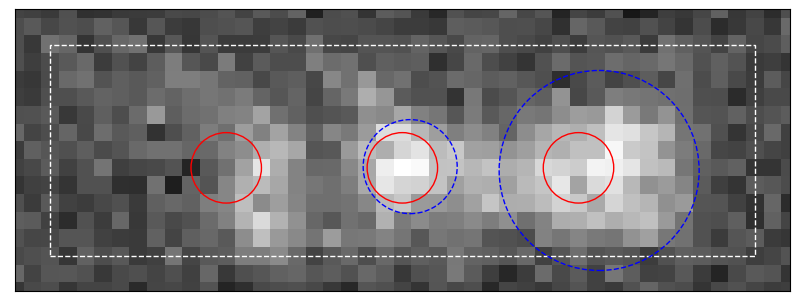

In [88]:
#plot the cell
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(np.sum(a["map"],axis=0),cmap="gray")
#restrict the axis to the cell space
#restrict the axis to the cell space +- 2 pixels
ax.set_xlim(cell_parms["cell_space"][0]-2,cell_parms["cell_space"][1]+2)
ax.set_ylim(cell_parms["cell_space"][2]-2,cell_parms["cell_space"][3]+2)
rect = plt.Rectangle((cell_parms["cell_space"][0],cell_parms["cell_space"][2]), cell_parms["cell_space"][1]-cell_parms["cell_space"][0], cell_parms["cell_space"][3]-cell_parms["cell_space"][2], color='w', fill=False,linestyle='--')
ax.add_artist(rect)
#plot the foci as a circle with center and radius defined by the initial centers and scale
for j in range(len(initial_dict["initial_centers"])):
    circle = plt.Circle((initial_dict["initial_centers"][j][0],initial_dict["initial_centers"][j][1]), initial_dict["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax.add_artist(circle)
#plot the detected foci
for j in range(len(c["Fitted"])):
    circle = plt.Circle((c["Fitted"][j][1],c["Fitted"][j][0]), np.mean([c["Fitted"][j][3],c["Fitted"][j][2]]), color='b', fill=False, linestyle='--',linewidth=1)
    ax.add_artist(circle)
#remove the ticks
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [7]:
#utility function to create the parameter dics

def utility_params(initial_dict,num_tracks,mean_track_length,density_dif,track_distribution,psf):
    initial_dict = initial_dict
    cell_parms = {
        "diffusion_coefficients":np.array(list(0.45*np.ones(num_tracks))),
        "initials": initial_dict,
        "num_tracks":num_tracks,
        "track_type":"fbm",
        "hursts":np.array(list(0.2*np.ones(num_tracks))),
        "dims":(200,200),
        "movie_frames":500,
        "cell_space":np.array([80,120,90,105])
    }     
    global_sim_params = {
        "track_length_mean":mean_track_length,
        "track_distribution":track_distribution,
        "exposure_time":20,#ms same as frame_time
        "base_noise":140,
        "point_intensity":20,
        "psf_sigma":psf,
        "frame_time":20,#ms
        "pixel_size":130,
        "axial_function":"exponential",
        "density_dif": density_dif
    }
    return initial_dict,cell_parms,global_sim_params


    

In [8]:
#lets set up a range of condensates to simulate
ID_same_size_1 = {
    "initial_centers":np.array([[100,100]]),
    "initial_scale": np.array([2]),
    "diffusion_coefficient": np.array([0]),
    "hurst_exponent": np.array([0.2])  
}
ID_same_size_2 = {
    "initial_centers":np.array([[100,100],[90,95]]),
    "initial_scale": np.array([2,2]),
    "diffusion_coefficient": np.array([0,0]),
    "hurst_exponent": np.array([0.2,0.2])
}
ID_same_size_3 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100]]),
    "initial_scale": np.array([2,2,2]),
    "diffusion_coefficient": np.array([0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2])
}
ID_same_size_4 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100],[115,95]]),
    "initial_scale": np.array([2,2,2,2]),
    "diffusion_coefficient": np.array([0,0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2,0.2])
}

initial_dict_collection_same_size = [ID_same_size_1,ID_same_size_2,ID_same_size_3,ID_same_size_4]



In [9]:
#lets make a utility function to perform the scale-space
def scale_utility(img_map,threshold):
    b = blob_detection(path = img_map,\
                    median= False,\
                    threshold= threshold, \
                    min_sigma= 1/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 500, \
                    overlap = 0.5, \
                    logscale=False,
                    verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":5,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":2,
                                "centroid_range":2})
    c = b.detection(type = "bp")
    return c

In [145]:
#sim one blob 
ID_same_size_1_sim, cell_parms_1_sim, global_sim_params_1_sim = utility_params(ID_same_size_1,1000,1,5,"constant",1.)
cell_sim_1_sim = simulate_cells.Simulate_cells(cell_parms_1_sim,global_sim_params_1_sim)
a_1_sim = cell_sim_1_sim.get_cell()

#sim two blobs
ID_same_size_2_sim, cell_parms_2_sim, global_sim_params_2_sim = utility_params(ID_same_size_2,1000,1,5,"constant",1.)
cell_sim_2_sim = simulate_cells.Simulate_cells(cell_parms_2_sim,global_sim_params_2_sim)
a_2_sim = cell_sim_2_sim.get_cell()

#sim three blobs
ID_same_size_3_sim, cell_parms_3_sim, global_sim_params_3_sim = utility_params(ID_same_size_3,1000,1,5,"constant",1.)
cell_sim_3_sim = simulate_cells.Simulate_cells(cell_parms_3_sim,global_sim_params_3_sim)
a_3_sim = cell_sim_3_sim.get_cell()

#sim four blobs
ID_same_size_4_sim, cell_parms_4_sim, global_sim_params_4_sim = utility_params(ID_same_size_4,1000,1,5,"constant",1.)
cell_sim_4_sim = simulate_cells.Simulate_cells(cell_parms_4_sim,global_sim_params_4_sim)
a_4_sim = cell_sim_4_sim.get_cell()



In [146]:
#lets perform scale selection on the simulated data
c_1_sim = scale_utility(img_map = np.sum(a_1_sim["map"],axis=0),threshold = 1.1e3)
c_2_sim = scale_utility(img_map = np.sum(a_2_sim["map"],axis=0),threshold = 1.1e3)
c_3_sim = scale_utility(img_map = np.sum(a_3_sim["map"],axis=0),threshold = 1.1e3)
c_4_sim = scale_utility(img_map = np.sum(a_4_sim["map"],axis=0),threshold = 1.1e3)



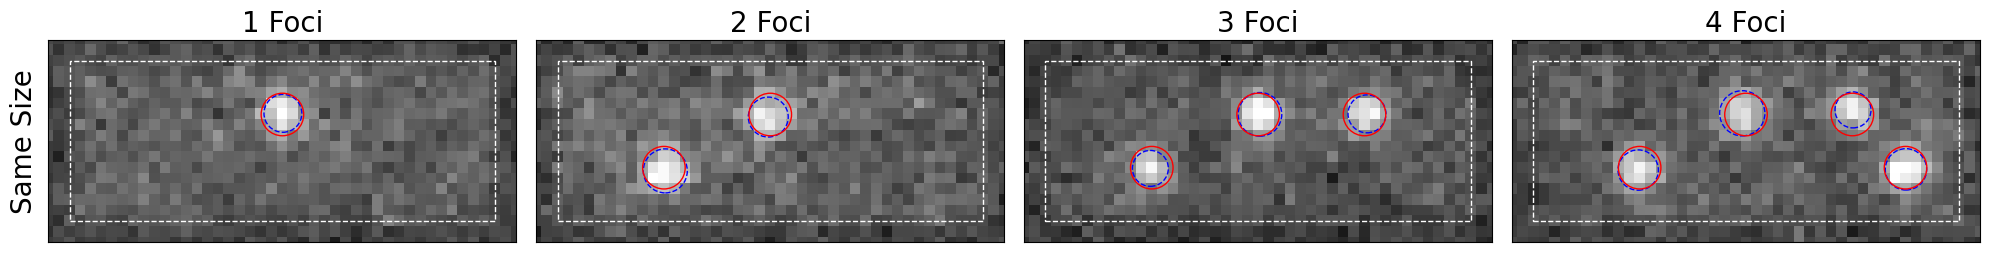

In [179]:
#plot the cell
fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(1, 4)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(np.sum(a_1_sim["map"],axis=0),cmap="gray")
#plot the blob detection
for j in range(len(c_1_sim["Fitted"])):
    circle = plt.Circle((c_1_sim["Fitted"][j][1],c_1_sim["Fitted"][j][0]), np.mean([c_1_sim["Fitted"][j][3],c_1_sim["Fitted"][j][2]]), color='b', fill=False, linestyle='--',linewidth=1)
    ax1.add_artist(circle)
#plot the true foci
for j in range(len(ID_same_size_1_sim["initial_centers"])):
    circle = plt.Circle((ID_same_size_1_sim["initial_centers"][j][0],ID_same_size_1_sim["initial_centers"][j][1]), ID_same_size_1_sim["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax1.add_artist(circle)


ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(np.sum(a_2_sim["map"],axis=0),cmap="gray")
#plot the blob detection
for j in range(len(c_2_sim["Fitted"])):
    circle = plt.Circle((c_2_sim["Fitted"][j][1],c_2_sim["Fitted"][j][0]), np.mean([c_2_sim["Fitted"][j][3],c_2_sim["Fitted"][j][2]]), color='b', fill=False, linestyle='--',linewidth=1)
    ax2.add_artist(circle)
#plot the true foci
for j in range(len(ID_same_size_2_sim["initial_centers"])):
    circle = plt.Circle((ID_same_size_2_sim["initial_centers"][j][0],ID_same_size_2_sim["initial_centers"][j][1]), ID_same_size_2_sim["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax2.add_artist(circle)


ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(np.sum(a_3_sim["map"],axis=0),cmap="gray")
#plot the blob detection
for j in range(len(c_3_sim["Fitted"])):
    circle = plt.Circle((c_3_sim["Fitted"][j][1],c_3_sim["Fitted"][j][0]), np.mean([c_3_sim["Fitted"][j][3],c_3_sim["Fitted"][j][2]]), color='b', fill=False, linestyle='--',linewidth=1)
    ax3.add_artist(circle)
#plot the true foci
for j in range(len(ID_same_size_3_sim["initial_centers"])):
    circle = plt.Circle((ID_same_size_3_sim["initial_centers"][j][0],ID_same_size_3_sim["initial_centers"][j][1]), ID_same_size_3_sim["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax3.add_artist(circle)

ax4 = fig.add_subplot(gs[0, 3])
ax4.imshow(np.sum(a_4_sim["map"],axis=0),cmap="gray")
#plot the blob detection
for j in range(len(c_4_sim["Fitted"])):
    circle = plt.Circle((c_4_sim["Fitted"][j][1],c_4_sim["Fitted"][j][0]), np.mean([c_4_sim["Fitted"][j][3],c_4_sim["Fitted"][j][2]]), color='b', fill=False, linestyle='--',linewidth=1)
    ax4.add_artist(circle)
#plot the true foci
for j in range(len(ID_same_size_4_sim["initial_centers"])):
    circle = plt.Circle((ID_same_size_4_sim["initial_centers"][j][0],ID_same_size_4_sim["initial_centers"][j][1]), ID_same_size_4_sim["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax4.add_artist(circle)


#restrict the axis to the cell space
#restrict the axis to the cell space +- 2 pixels
ax1.set_xlim(cell_parms_1_sim["cell_space"][0]-2,cell_parms_1_sim["cell_space"][1]+2)
ax1.set_ylim(cell_parms_1_sim["cell_space"][2]-2,cell_parms_1_sim["cell_space"][3]+2)
ax2.set_xlim(cell_parms_2_sim["cell_space"][0]-2,cell_parms_2_sim["cell_space"][1]+2)
ax2.set_ylim(cell_parms_2_sim["cell_space"][2]-2,cell_parms_2_sim["cell_space"][3]+2)
ax3.set_xlim(cell_parms_3_sim["cell_space"][0]-2,cell_parms_3_sim["cell_space"][1]+2)
ax3.set_ylim(cell_parms_3_sim["cell_space"][2]-2,cell_parms_3_sim["cell_space"][3]+2)
ax4.set_xlim(cell_parms_4_sim["cell_space"][0]-2,cell_parms_4_sim["cell_space"][1]+2)
ax4.set_ylim(cell_parms_4_sim["cell_space"][2]-2,cell_parms_4_sim["cell_space"][3]+2)

#add the rectangle
rect1 = plt.Rectangle((cell_parms_1_sim["cell_space"][0],cell_parms_1_sim["cell_space"][2]), cell_parms_1_sim["cell_space"][1]-cell_parms_1_sim["cell_space"][0], cell_parms_1_sim["cell_space"][3]-cell_parms_1_sim["cell_space"][2], color='w', fill=False,linestyle='--')
ax1.add_artist(rect1)
rect2 = plt.Rectangle((cell_parms_2_sim["cell_space"][0],cell_parms_2_sim["cell_space"][2]), cell_parms_2_sim["cell_space"][1]-cell_parms_2_sim["cell_space"][0], cell_parms_2_sim["cell_space"][3]-cell_parms_2_sim["cell_space"][2], color='w', fill=False,linestyle='--')
ax2.add_artist(rect2)
rect3 = plt.Rectangle((cell_parms_3_sim["cell_space"][0],cell_parms_3_sim["cell_space"][2]), cell_parms_3_sim["cell_space"][1]-cell_parms_3_sim["cell_space"][0], cell_parms_3_sim["cell_space"][3]-cell_parms_3_sim["cell_space"][2], color='w', fill=False,linestyle='--')
ax3.add_artist(rect3)
rect4 = plt.Rectangle((cell_parms_4_sim["cell_space"][0],cell_parms_4_sim["cell_space"][2]), cell_parms_4_sim["cell_space"][1]-cell_parms_4_sim["cell_space"][0], cell_parms_4_sim["cell_space"][3]-cell_parms_4_sim["cell_space"][2], color='w', fill=False,linestyle='--')
ax4.add_artist(rect4)

#remove the ticks
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])
#for the ylabel on the first plot write Sample Simulations
ax1.set_ylabel("Same Size",fontsize=20)
#make the title for each plot
ax1.set_title("1 Foci",fontsize=20)
ax2.set_title("2 Foci",fontsize=20)
ax3.set_title("3 Foci",fontsize=20)
ax4.set_title("4 Foci",fontsize=20)
plt.tight_layout()
plt.show()

In [10]:
#define a utility function to detect the true positives and the error in the centers and scale
def true_positive_and_erros(true_clusters,found_clusters,center_threshold=0.5):
    '''true clusters is the initial_dict, the found is the scale space output from the blob detection'''
    #get the true centers and scale
    true_centers = true_clusters["initial_centers"]
    true_scale = true_clusters["initial_scale"]
    #get the found centers and scale
    found_centers = np.array([found_clusters["Fitted"][i][:2] for i in range(len(found_clusters["Fitted"]))])

    found_scale = np.array([np.mean([found_clusters["Fitted"][i][2],found_clusters["Fitted"][i][3]]) for i in range(len(found_clusters["Fitted"]))])
    #get the true positives
    true_center_TP_center_error = np.ones(len(true_centers))*np.nan
    true_center_TP_scale_error = np.ones(len(true_centers))*np.nan
    for i in range(len(true_centers)):
        for j in range(len(found_centers)):
            if np.linalg.norm(true_centers[i]-found_centers[j][::-1])<center_threshold:
                if true_center_TP_center_error[i] > np.linalg.norm(true_centers[i]-found_centers[j][::-1]) or np.isnan(true_center_TP_center_error[i]):
                    true_center_TP_center_error[i] = np.linalg.norm(true_centers[i]-found_centers[j][::-1])
                    true_center_TP_scale_error[i] = np.abs(true_scale[i]-found_scale[j])/true_scale[i]

    #get the false positives
    #this is just the total number of found centers minus the true positives (len of the true_center_TP_center_error without the nans)
    false_positives = len(found_centers)-len(true_center_TP_center_error[~np.isnan(true_center_TP_center_error)])
    #get the true positives
    true_positive_num = len(true_center_TP_center_error[~np.isnan(true_center_TP_center_error)])

    
    return true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error


    


In [192]:
#test this on the sample data
true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error = true_positive_and_erros(ID_same_size_4_sim,c_4_sim,center_threshold=1)
print("True Positive Number: ",true_positive_num)
print("False Positive Number: ",false_positives)
print("True Center Error: ",true_center_TP_center_error)
print("True Scale Error: ",true_center_TP_scale_error)


True Positive Number:  4
False Positive Number:  0
True Center Error:  [0.36952965 0.2624177  0.43643797 0.16250412]
True Scale Error:  [0.06262657 0.05141612 0.1543153  0.02761706]


In [212]:
#now that we have done a sample simulation lets do a range of simulations for different lengths of tracks and also for 3 repeats for each
#lets set up a range of lengths of tracks to simulate
track_lengths = np.array([300,600,900,1200,1500,1800,2100])
repeats = 1
threshold = 1.1e3
#we are going to use ID_same_size_1_sim-4_sim as the initial dict
#collection of TP and FP and center and scale errors
map_collection_ID_same_size_1 = np.zeros((len(track_lengths),repeats,200,200))
TP_collection_ID_same_size_1 = np.zeros((len(track_lengths),repeats))
FP_collection_ID_same_size_1 = np.zeros((len(track_lengths),repeats))
center_error_collection_ID_same_size_1 = np.zeros((len(track_lengths),repeats,len(ID_same_size_1_sim["initial_centers"])))
scale_error_collection_ID_same_size_1 = np.zeros((len(track_lengths),repeats,len(ID_same_size_1_sim["initial_centers"])))

map_collection_ID_same_size_2 = np.zeros((len(track_lengths),repeats,200,200))
TP_collection_ID_same_size_2 = np.zeros((len(track_lengths),repeats))
FP_collection_ID_same_size_2 = np.zeros((len(track_lengths),repeats))
center_error_collection_ID_same_size_2 = np.zeros((len(track_lengths),repeats,len(ID_same_size_2_sim["initial_centers"])))
scale_error_collection_ID_same_size_2 = np.zeros((len(track_lengths),repeats,len(ID_same_size_2_sim["initial_centers"])))

map_collection_ID_same_size_3 = np.zeros((len(track_lengths),repeats,200,200))
TP_collection_ID_same_size_3 = np.zeros((len(track_lengths),repeats))
FP_collection_ID_same_size_3 = np.zeros((len(track_lengths),repeats))
center_error_collection_ID_same_size_3 = np.zeros((len(track_lengths),repeats,len(ID_same_size_3_sim["initial_centers"])))
scale_error_collection_ID_same_size_3 = np.zeros((len(track_lengths),repeats,len(ID_same_size_3_sim["initial_centers"])))

map_collection_ID_same_size_4 = np.zeros((len(track_lengths),repeats,200,200))
TP_collection_ID_same_size_4 = np.zeros((len(track_lengths),repeats))
FP_collection_ID_same_size_4 = np.zeros((len(track_lengths),repeats))
center_error_collection_ID_same_size_4 = np.zeros((len(track_lengths),repeats,len(ID_same_size_4_sim["initial_centers"])))
scale_error_collection_ID_same_size_4 = np.zeros((len(track_lengths),repeats,len(ID_same_size_4_sim["initial_centers"])))




In [213]:
#lets do this for each track number
for i in range(len(track_lengths)):
    #lets do this for each repeat
    for j in range(repeats):
        #lets simulate the data
        ID_same_size_1_sim, cell_parms_1_sim, global_sim_params_1_sim = utility_params(ID_same_size_1,track_lengths[i],1,5,"constant",1.)
        cell_sim_1_sim = simulate_cells.Simulate_cells(cell_parms_1_sim,global_sim_params_1_sim)
        a_1_sim = cell_sim_1_sim.get_cell()
        map_collection_ID_same_size_1[i,j,:,:] = np.sum(a_1_sim["map"],axis=0)
        #lets perform scale selection on the simulated data
        c_1_sim = scale_utility(img_map = np.sum(a_1_sim["map"],axis=0),threshold = threshold)
        #lets get the true positives and errors
        true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error = true_positive_and_erros(ID_same_size_1_sim,c_1_sim,center_threshold=1)
        #lets store the results
        TP_collection_ID_same_size_1[i,j] = true_positive_num
        FP_collection_ID_same_size_1[i,j] = false_positives
        center_error_collection_ID_same_size_1[i,j,:] = true_center_TP_center_error
        scale_error_collection_ID_same_size_1[i,j,:] = true_center_TP_scale_error
    #print updates
    print("Completed: ",i+1,"/",len(track_lengths))


Completed:  1 / 7
Completed:  2 / 7
Completed:  3 / 7
Completed:  4 / 7
Completed:  5 / 7
Completed:  6 / 7
Completed:  7 / 7


In [214]:
#lets repeat for ID_same_size_2
for i in range(len(track_lengths)):
    #lets do this for each repeat
    for j in range(repeats):
        #lets simulate the data
        ID_same_size_2_sim, cell_parms_2_sim, global_sim_params_2_sim = utility_params(ID_same_size_2,track_lengths[i],1,5,"constant",1.)
        cell_sim_2_sim = simulate_cells.Simulate_cells(cell_parms_2_sim,global_sim_params_2_sim)
        a_2_sim = cell_sim_2_sim.get_cell()
        map_collection_ID_same_size_2[i,j,:,:] = np.sum(a_2_sim["map"],axis=0)
        #lets perform scale selection on the simulated data
        c_2_sim = scale_utility(img_map = np.sum(a_2_sim["map"],axis=0),threshold = threshold)
        #lets get the true positives and errors
        true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error = true_positive_and_erros(ID_same_size_2_sim,c_2_sim,center_threshold=1)
        #lets store the results
        TP_collection_ID_same_size_2[i,j] = true_positive_num
        FP_collection_ID_same_size_2[i,j] = false_positives
        center_error_collection_ID_same_size_2[i,j,:] = true_center_TP_center_error
        scale_error_collection_ID_same_size_2[i,j,:] = true_center_TP_scale_error
    
#lets repeat for ID_same_size_3
for i in range(len(track_lengths)):
    #lets do this for each repeat
    for j in range(repeats):
        #lets simulate the data
        ID_same_size_3_sim, cell_parms_3_sim, global_sim_params_3_sim = utility_params(ID_same_size_3,track_lengths[i],1,5,"constant",1.)
        cell_sim_3_sim = simulate_cells.Simulate_cells(cell_parms_3_sim,global_sim_params_3_sim)
        a_3_sim = cell_sim_3_sim.get_cell()
        map_collection_ID_same_size_3[i,j,:,:] = np.sum(a_3_sim["map"],axis=0)
        #lets perform scale selection on the simulated data
        c_3_sim = scale_utility(img_map = np.sum(a_3_sim["map"],axis=0),threshold = threshold)
        #lets get the true positives and errors
        true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error = true_positive_and_erros(ID_same_size_3_sim,c_3_sim,center_threshold=1)
        #lets store the results
        TP_collection_ID_same_size_3[i,j] = true_positive_num
        FP_collection_ID_same_size_3[i,j] = false_positives
        center_error_collection_ID_same_size_3[i,j,:] = true_center_TP_center_error
        scale_error_collection_ID_same_size_3[i,j,:] = true_center_TP_scale_error

#lets repeat for ID_same_size_4
for i in range(len(track_lengths)):
    #lets do this for each repeat
    for j in range(repeats):
        #lets simulate the data
        ID_same_size_4_sim, cell_parms_4_sim, global_sim_params_4_sim = utility_params(ID_same_size_4,track_lengths[i],1,5,"constant",1.)
        cell_sim_4_sim = simulate_cells.Simulate_cells(cell_parms_4_sim,global_sim_params_4_sim)
        a_4_sim = cell_sim_4_sim.get_cell()
        map_collection_ID_same_size_4[i,j,:,:] = np.sum(a_4_sim["map"],axis=0)
        #lets perform scale selection on the simulated data
        c_4_sim = scale_utility(img_map = np.sum(a_4_sim["map"],axis=0),threshold = threshold)
        #lets get the true positives and errors
        true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error = true_positive_and_erros(ID_same_size_4_sim,c_4_sim,center_threshold=1)
        #lets store the results
        TP_collection_ID_same_size_4[i,j] = true_positive_num
        FP_collection_ID_same_size_4[i,j] = false_positives
        center_error_collection_ID_same_size_4[i,j,:] = true_center_TP_center_error
        scale_error_collection_ID_same_size_4[i,j,:] = true_center_TP_scale_error


In [215]:
#import pickle
import pickle

In [216]:
#lets save the collection to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Same_Size_threshold_1e3 
num_1_file_data = [TP_collection_ID_same_size_1,FP_collection_ID_same_size_1,center_error_collection_ID_same_size_1,scale_error_collection_ID_same_size_1,map_collection_ID_same_size_1]
num_2_file_data = [TP_collection_ID_same_size_2,FP_collection_ID_same_size_2,center_error_collection_ID_same_size_2,scale_error_collection_ID_same_size_2,map_collection_ID_same_size_2]
num_3_file_data = [TP_collection_ID_same_size_3,FP_collection_ID_same_size_3,center_error_collection_ID_same_size_3,scale_error_collection_ID_same_size_3,map_collection_ID_same_size_3]
num_4_file_data = [TP_collection_ID_same_size_4,FP_collection_ID_same_size_4,center_error_collection_ID_same_size_4,scale_error_collection_ID_same_size_4,map_collection_ID_same_size_4]
SAVE = False
if SAVE == True:
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Same_Size_threshold_1e3/num_1_file_data.pkl', 'wb') as f:
        pickle.dump(num_1_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Same_Size_threshold_1e3/num_2_file_data.pkl', 'wb') as f:
        pickle.dump(num_2_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Same_Size_threshold_1e3/num_3_file_data.pkl', 'wb') as f:
        pickle.dump(num_3_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Same_Size_threshold_1e3/num_4_file_data.pkl', 'wb') as f:
        pickle.dump(num_4_file_data, f)

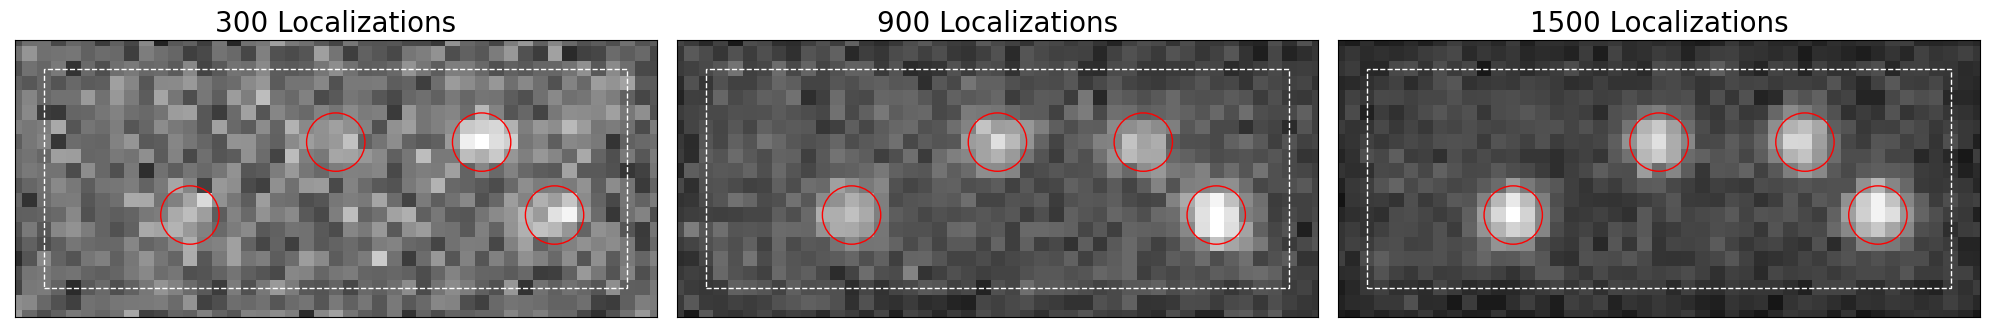

In [252]:
#lets make a figure where we plot the map for 3 different track lengths (0,2,4) index 
fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(map_collection_ID_same_size_4[0,0,:,:],cmap="gray")
ax1.set_title("300 Localizations",fontsize=20)
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(map_collection_ID_same_size_4[2,0,:,:],cmap="gray")
ax2.set_title("900 Localizations",fontsize=20)
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(map_collection_ID_same_size_4[4,0,:,:],cmap="gray")
ax3.set_title("1500 Localizations",fontsize=20)

#lets plot the rectangle
rect1 = plt.Rectangle((cell_parms_1_sim["cell_space"][0],cell_parms_1_sim["cell_space"][2]), cell_parms_1_sim["cell_space"][1]-cell_parms_1_sim["cell_space"][0], cell_parms_1_sim["cell_space"][3]-cell_parms_1_sim["cell_space"][2], color='w', fill=False,linestyle='--')
ax1.add_artist(rect1)
rect2 = plt.Rectangle((cell_parms_1_sim["cell_space"][0],cell_parms_1_sim["cell_space"][2]), cell_parms_1_sim["cell_space"][1]-cell_parms_1_sim["cell_space"][0], cell_parms_1_sim["cell_space"][3]-cell_parms_1_sim["cell_space"][2], color='w', fill=False,linestyle='--')
ax2.add_artist(rect2)
rect3 = plt.Rectangle((cell_parms_1_sim["cell_space"][0],cell_parms_1_sim["cell_space"][2]), cell_parms_1_sim["cell_space"][1]-cell_parms_1_sim["cell_space"][0], cell_parms_1_sim["cell_space"][3]-cell_parms_1_sim["cell_space"][2], color='w', fill=False,linestyle='--')
ax3.add_artist(rect3)

#plot the true foci
for j in range(len(ID_same_size_4_sim["initial_centers"])):
    circle1 = plt.Circle((ID_same_size_4_sim["initial_centers"][j][0],ID_same_size_4_sim["initial_centers"][j][1]), ID_same_size_4_sim["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    circle2 = plt.Circle((ID_same_size_4_sim["initial_centers"][j][0],ID_same_size_4_sim["initial_centers"][j][1]), ID_same_size_4_sim["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    circle3 = plt.Circle((ID_same_size_4_sim["initial_centers"][j][0],ID_same_size_4_sim["initial_centers"][j][1]), ID_same_size_4_sim["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax1.add_artist(circle1)
    ax2.add_artist(circle2)
    ax3.add_artist(circle3)

#remove the ticks
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])

#restrict the axis to the cell space +- 2 pixels
ax1.set_xlim(cell_parms_1_sim["cell_space"][0]-2,cell_parms_1_sim["cell_space"][1]+2)
ax1.set_ylim(cell_parms_1_sim["cell_space"][2]-2,cell_parms_1_sim["cell_space"][3]+2)
ax2.set_xlim(cell_parms_1_sim["cell_space"][0]-2,cell_parms_1_sim["cell_space"][1]+2)
ax2.set_ylim(cell_parms_1_sim["cell_space"][2]-2,cell_parms_1_sim["cell_space"][3]+2)
ax3.set_xlim(cell_parms_1_sim["cell_space"][0]-2,cell_parms_1_sim["cell_space"][1]+2)
ax3.set_ylim(cell_parms_1_sim["cell_space"][2]-2,cell_parms_1_sim["cell_space"][3]+2)

plt.tight_layout()
SAVE = False
if SAVE == True:
    plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Same_Size_threshold_1e3/Same_Size_300_900_1500.svg",format="svg",dpi=200)
    
plt.show()

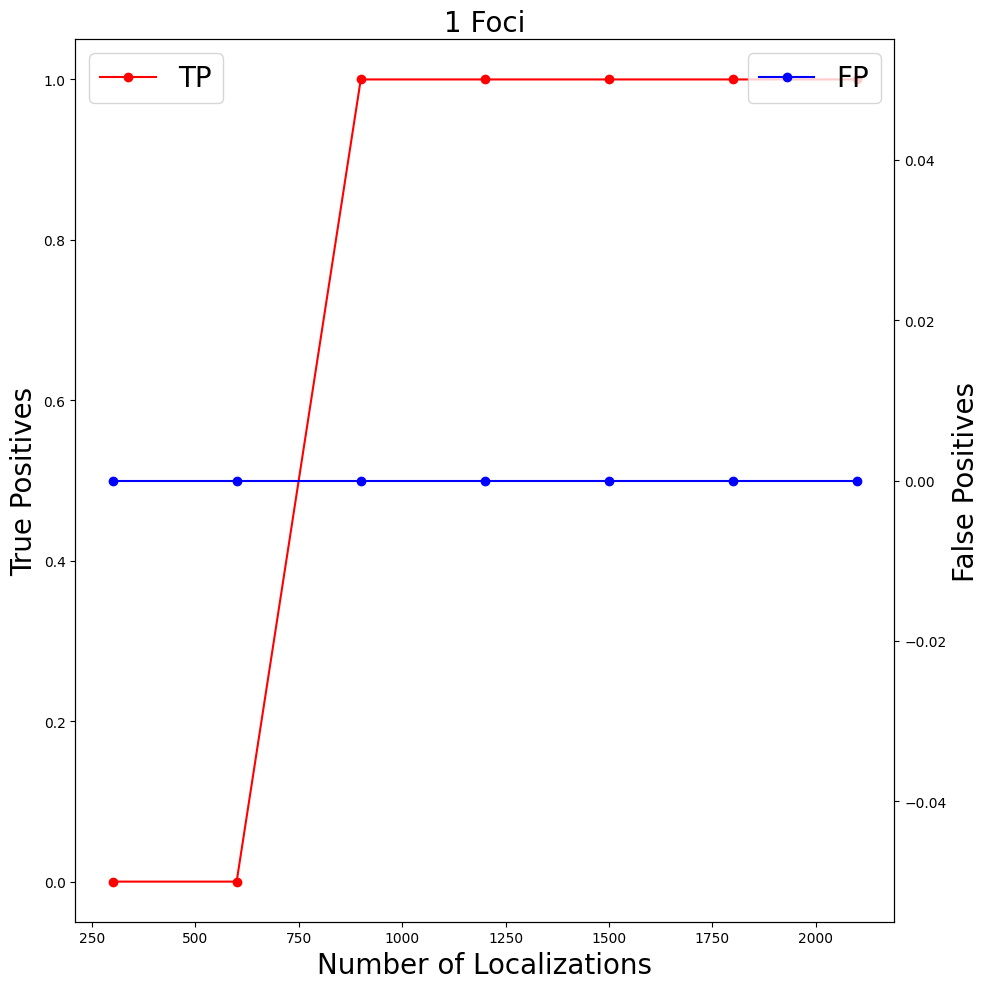

In [248]:
#lets plot the TP and FP for each track length
#the TP is on one yaxis and the FP is on the other yaxis
fig, ax1 = plt.subplots(figsize=(10,10))
ax2 = ax1.twinx()
ax1.plot(track_lengths,np.mean(TP_collection_ID_same_size_1,axis=1),color="r",label="TP",marker="o")
ax2.plot(track_lengths,np.mean(FP_collection_ID_same_size_1,axis=1),color="b",label="FP",marker="o")
ax1.set_xlabel("Number of Localizations",fontsize=20)
ax1.set_ylabel("True Positives",fontsize=20)
ax2.set_ylabel("False Positives",fontsize=20)
ax1.set_title("1 Foci",fontsize=20)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20)
plt.tight_layout()


ValueError: x and y must have same first dimension, but have shapes (15,) and (7,)

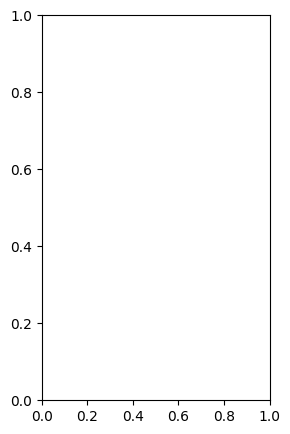

In [346]:
#okay lets just plot the TP,c error, s error for each localization number for each of the 4 foci on a single plot with x being the 1-4 foci
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])

#the first one is the TP for each number of localizations (x axis is the number of localizations)
ax1.plot(track_lengths,np.mean(TP_collection_ID_same_size_1,axis=1)/1.,color="r",label="1 Foci",marker="o",alpha = 0.5)
ax1.plot(track_lengths,np.mean(TP_collection_ID_same_size_2,axis=1)/2.,color="b",label="2 Foci",marker="o",alpha = 0.5)
ax1.plot(track_lengths,np.mean(TP_collection_ID_same_size_3,axis=1)/3.,color="g",label="3 Foci",marker="o",alpha = 0.5)
ax1.plot(track_lengths,np.mean(TP_collection_ID_same_size_4,axis=1)/4.,color="k",label="4 Foci",marker="o",alpha = 0.5)
ax1.set_xlabel("Number of Localizations",fontsize=10)
ax1.set_ylabel("True Positive Rate",fontsize=10)
ax1.set_title("True Positive Rate",fontsize=10)
ax1.legend(fontsize=10)

#for the second one do the scale error
ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(track_lengths,np.mean(np.mean(scale_error_collection_ID_same_size_1,axis=1),axis=1),yerr=np.std(np.mean(scale_error_collection_ID_same_size_1,axis=1),axis=1),color="r",label="1 Foci",marker="o")
ax2.errorbar(track_lengths,np.mean(np.mean(scale_error_collection_ID_same_size_2,axis=1),axis=1),yerr=np.std(np.mean(scale_error_collection_ID_same_size_2,axis=1),axis=1),color="b",label="2 Foci",marker="o")
ax2.errorbar(track_lengths,np.mean(np.mean(scale_error_collection_ID_same_size_3,axis=1),axis=1),yerr=np.std(np.mean(scale_error_collection_ID_same_size_3,axis=1),axis=1),color="g",label="3 Foci",marker="o")
ax2.errorbar(track_lengths,np.mean(np.mean(scale_error_collection_ID_same_size_4,axis=1),axis=1),yerr=np.std(np.mean(scale_error_collection_ID_same_size_4,axis=1),axis=1),color="k",label="4 Foci",marker="o")
ax2.set_xlabel("Number of Localizations",fontsize=10)
ax2.set_ylabel("Percent Size Error",fontsize=10)
ax2.set_title("Percent Size Error",fontsize=10)
ax2.legend(fontsize=10)
ax2.set_ylim(0,1)

#for the third one do the center error
ax3 = fig.add_subplot(gs[0, 2])
ax3.errorbar(track_lengths,np.mean(np.mean(center_error_collection_ID_same_size_1,axis=1),axis=1),yerr=np.std(np.mean(center_error_collection_ID_same_size_1,axis=1),axis=1),color="r",label="1 Foci",marker="o")
ax3.errorbar(track_lengths,np.mean(np.mean(center_error_collection_ID_same_size_2,axis=1),axis=1),yerr=np.std(np.mean(center_error_collection_ID_same_size_2,axis=1),axis=1),color="b",label="2 Foci",marker="o")
ax3.errorbar(track_lengths,np.mean(np.mean(center_error_collection_ID_same_size_3,axis=1),axis=1),yerr=np.std(np.mean(center_error_collection_ID_same_size_3,axis=1),axis=1),color="g",label="3 Foci",marker="o")
ax3.errorbar(track_lengths,np.mean(np.mean(center_error_collection_ID_same_size_4,axis=1),axis=1),yerr=np.std(np.mean(center_error_collection_ID_same_size_4,axis=1),axis=1),color="k",label="4 Foci",marker="o")
ax3.set_xlabel("Number of Localizations",fontsize=10)
ax3.set_ylabel("Distance from True Center (pixel)",fontsize=10)
ax3.set_title("Center Error",fontsize=10)
ax3.legend(fontsize=10)
ax3.set_ylim(0,1)


#set the x limits to be the same for all
ax1.set_xlim(0,2100)
ax2.set_xlim(0,2100)
ax3.set_xlim(0,2100)



plt.tight_layout()
SAVE = False
if SAVE == True:
    plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Same_Size_threshold_1e3/TP_Center_Scale_Error.svg",format="svg",dpi=200)
plt.show()





In [284]:
#now what we need to do is vary the number of localizations and also the density dif for varying size of the cluster
#this will be for 2 scale sized cluster
#lets set up a range of lengths of tracks to simulate
track_lengths = np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500])
repeats = 3
threshold = 1e3
density_dif = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
#we are going to use ID_same_size_1_sim as the initial dict

#collection of TP and FP and center and scale errors
map_collection_ID_same_size_2_density_length = np.zeros((len(track_lengths),len(density_dif),repeats,200,200))
TP_collection_ID_same_size_2_density_length = np.zeros((len(track_lengths),len(density_dif),repeats))
FP_collection_ID_same_size_2_density_length = np.zeros((len(track_lengths),len(density_dif),repeats))
center_error_collection_ID_same_size_2_density_length = np.zeros((len(track_lengths),len(density_dif),repeats,len(ID_same_size_1_sim["initial_centers"])))
scale_error_collection_ID_same_size_2_density_length = np.zeros((len(track_lengths),len(density_dif),repeats,len(ID_same_size_1_sim["initial_centers"])))

for i in range(len(track_lengths)):
    for j in range(len(density_dif)):
        for k in range(repeats):
            #okay lets make the initial dict
            ID_same_size_1_sim_LD, cell_parms_1_sim_LD, global_sim_params_1_sim_LD = utility_params(ID_same_size_1,track_lengths[i],1,density_dif[j],"constant",1.)
            #lets simulate the data
            cell_sim_1_sim_LD = simulate_cells.Simulate_cells(cell_parms_1_sim_LD,global_sim_params_1_sim_LD)
            a_1_sim_LD = cell_sim_1_sim_LD.get_cell()
            map_collection_ID_same_size_2_density_length[i,j,k,:,:] = np.sum(a_1_sim_LD["map"],axis=0)
            #lets perform scale selection on the simulated data
            c_1_sim_LD = scale_utility(img_map = np.sum(a_1_sim_LD["map"],axis=0),threshold = threshold)
            #lets get the true positives and errors
            true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error = true_positive_and_erros(ID_same_size_1_sim_LD,c_1_sim_LD,center_threshold=1)
            #lets store the results
            TP_collection_ID_same_size_2_density_length[i,j,k] = true_positive_num
            FP_collection_ID_same_size_2_density_length[i,j,k] = false_positives
            center_error_collection_ID_same_size_2_density_length[i,j,k,:] = true_center_TP_center_error
            scale_error_collection_ID_same_size_2_density_length[i,j,k,:] = true_center_TP_scale_error
        #print updates
        print("Completed: ",i+1,"/",len(track_lengths)," ",j+1,"/",len(density_dif))





Completed:  1 / 15   1 / 15
Completed:  1 / 15   2 / 15
Completed:  1 / 15   3 / 15
Completed:  1 / 15   4 / 15
Completed:  1 / 15   5 / 15
Completed:  1 / 15   6 / 15
Completed:  1 / 15   7 / 15
Completed:  1 / 15   8 / 15
Completed:  1 / 15   9 / 15
Completed:  1 / 15   10 / 15
Completed:  1 / 15   11 / 15
Completed:  1 / 15   12 / 15
Completed:  1 / 15   13 / 15
Completed:  1 / 15   14 / 15
Completed:  1 / 15   15 / 15
Completed:  2 / 15   1 / 15
Completed:  2 / 15   2 / 15
Completed:  2 / 15   3 / 15
Completed:  2 / 15   4 / 15
Completed:  2 / 15   5 / 15
Completed:  2 / 15   6 / 15
Completed:  2 / 15   7 / 15
Completed:  2 / 15   8 / 15
Completed:  2 / 15   9 / 15
Completed:  2 / 15   10 / 15
Completed:  2 / 15   11 / 15
Completed:  2 / 15   12 / 15
Completed:  2 / 15   13 / 15
Completed:  2 / 15   14 / 15
Completed:  2 / 15   15 / 15
Completed:  3 / 15   1 / 15
Completed:  3 / 15   2 / 15
Completed:  3 / 15   3 / 15
Completed:  3 / 15   4 / 15
Completed:  3 / 15   5 / 15
Complete

In [286]:
#save the data to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix
file_data = [TP_collection_ID_same_size_2_density_length,FP_collection_ID_same_size_2_density_length,center_error_collection_ID_same_size_2_density_length,scale_error_collection_ID_same_size_2_density_length,map_collection_ID_same_size_2_density_length]
SAVE = False
if SAVE == True:
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix/num_1_file_data.pkl', 'wb') as f:
        pickle.dump(file_data, f)
    #save the track lengths and density dif
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix/track_lengths.pkl', 'wb') as f:
        pickle.dump(track_lengths, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix/density_dif.pkl', 'wb') as f:
        pickle.dump(density_dif, f)




/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_39396/1084337723.py:19: RuntimeWarning: Mean of empty slice
  Z = np.nanmean(np.nanmean(scale_error_collection_ID_same_size_2_density_length,axis=2),axis=2)


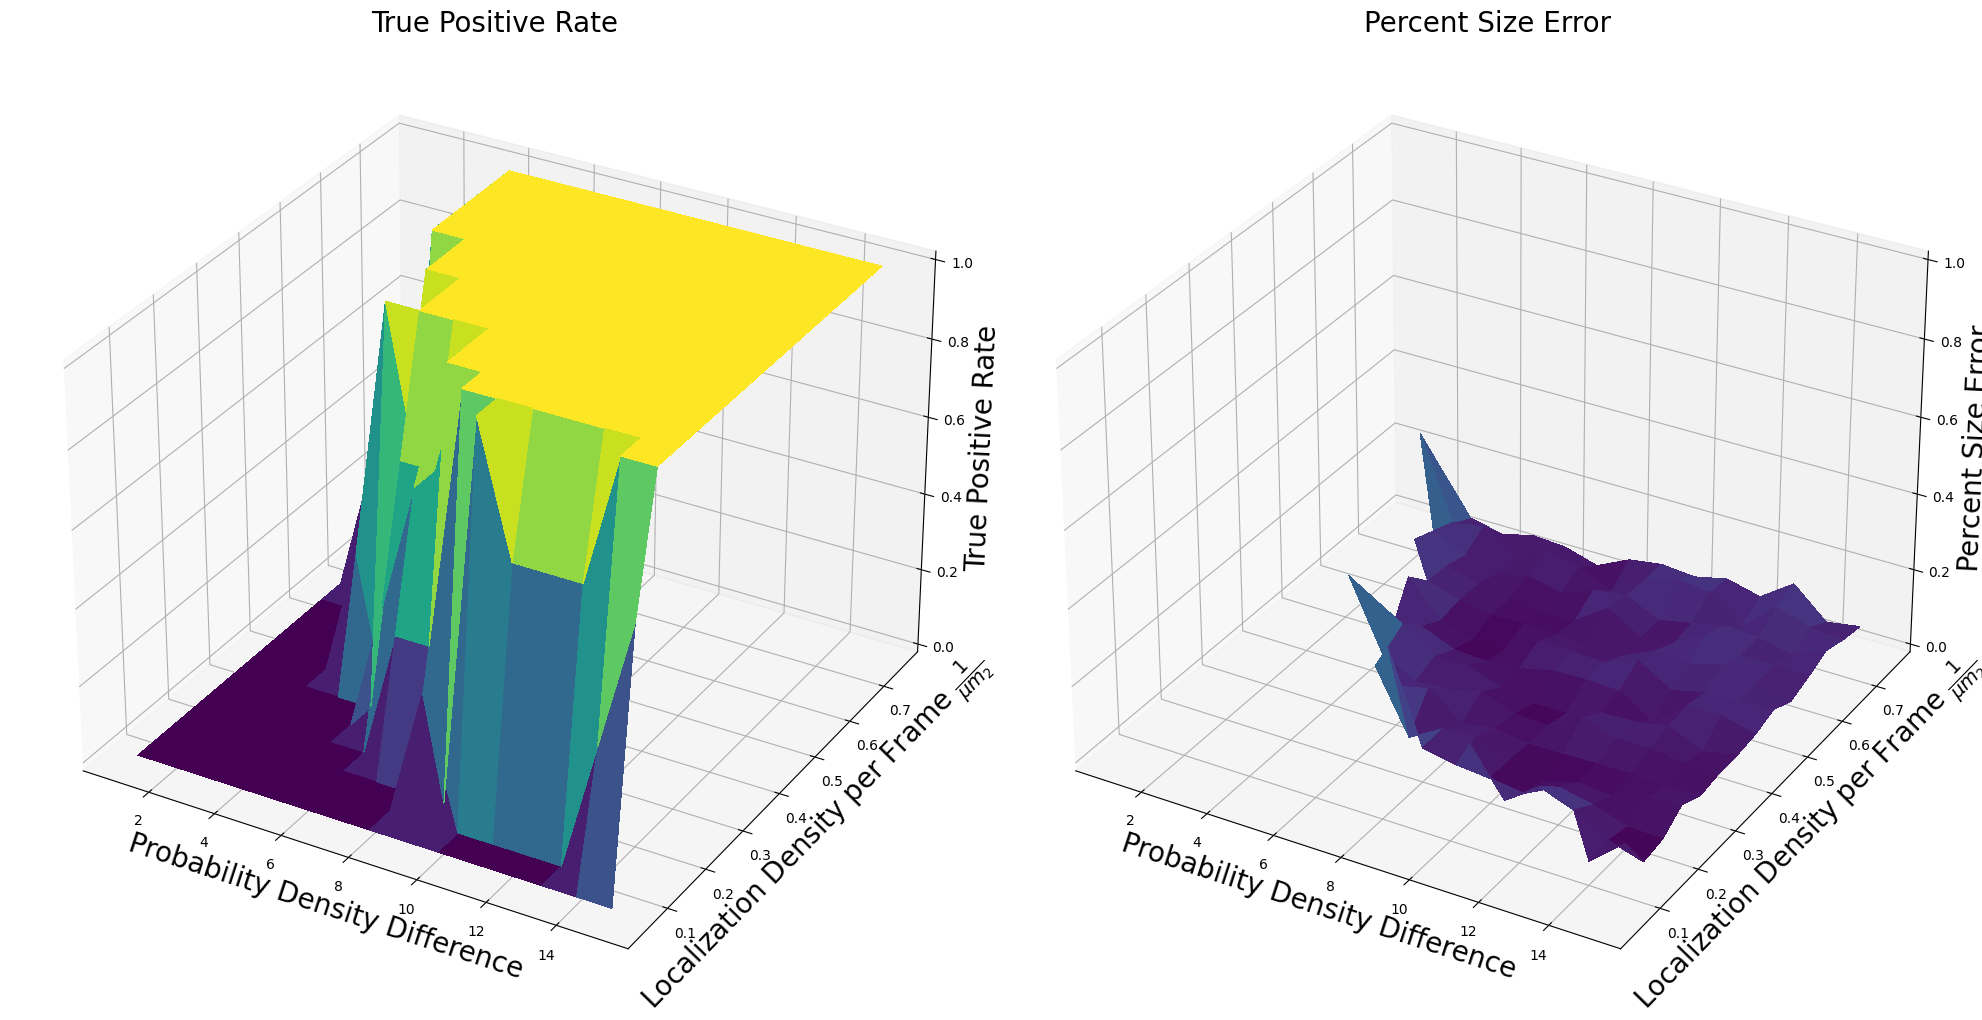

In [337]:
#plot the 3D plot of the TP for each track length and density dif by averaging over the repeats
#plot the center and scale error too
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0],projection='3d')
ax3 = fig.add_subplot(gs[0, 1],projection='3d')

#lets plot the TP
X, Y = np.meshgrid(density_dif, track_lengths/4/500.)
Z = np.mean(TP_collection_ID_same_size_2_density_length,axis=2)
surf = ax1.plot_surface(X, Y, Z,linewidth=0, antialiased=False,cmap="viridis")
ax1.set_xlabel("Probability Density Difference",fontsize=20)
ax1.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax1.set_zlabel("True Positive Rate",fontsize=20)
ax1.set_title("True Positive Rate",fontsize=20)

#lets plot the scale error
X, Y = np.meshgrid(density_dif, track_lengths/4/500.)
Z = np.nanmean(np.nanmean(scale_error_collection_ID_same_size_2_density_length,axis=2),axis=2)
surf = ax3.plot_surface(X, Y, Z,linewidth=0, antialiased=False,cmap="viridis")
ax3.set_xlabel("Probability Density Difference",fontsize=20)
ax3.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax3.set_zlabel("Percent Size Error",fontsize=20)
ax3.set_title("Percent Size Error",fontsize=20)
ax3.set_zlim(0,1)

plt.tight_layout()

SAVE = False
if SAVE == True:
    plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix/TP_Scale_Error.svg",format="svg",dpi=200)
plt.show()


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_39396/175540692.py:18: RuntimeWarning: Mean of empty slice
  Z = np.nanmean(np.nanmean(scale_error_collection_ID_same_size_2_density_length,axis=2),axis=2)


Text(0.5, 1.0, 'Percent Size Error')

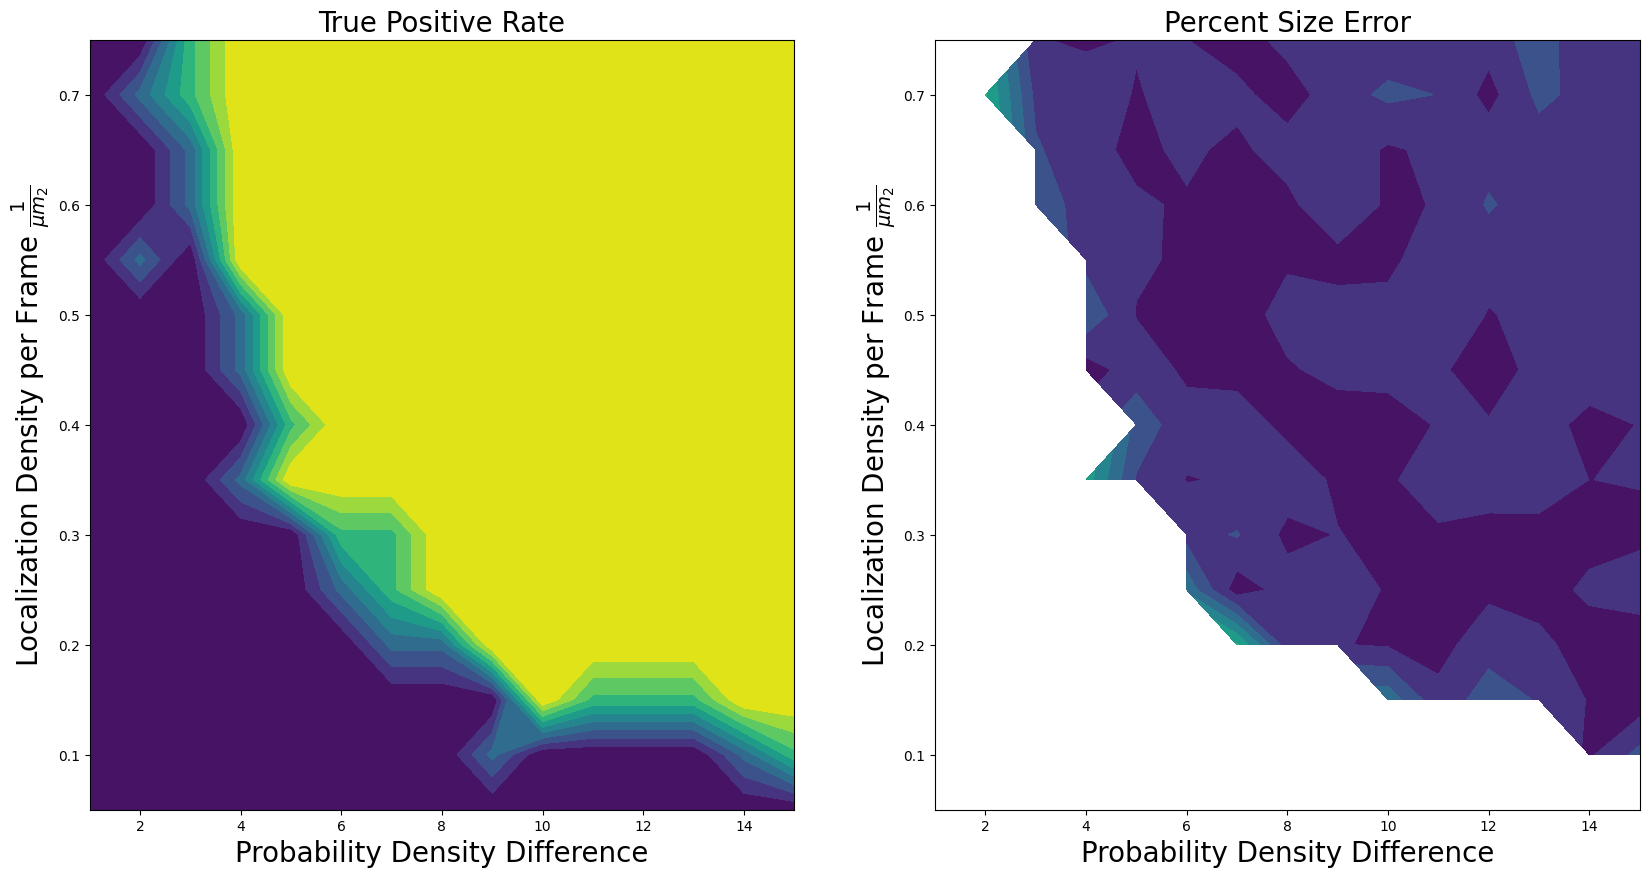

In [338]:
#repeat this but with a contour plot
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])

#lets plot the TP
X, Y = np.meshgrid(density_dif, track_lengths/4/500.)
Z = np.mean(TP_collection_ID_same_size_2_density_length,axis=2)
CS = ax1.contourf(X, Y, Z,levels=10,cmap="viridis")
ax1.set_xlabel("Probability Density Difference",fontsize=20)
ax1.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax1.set_title("True Positive Rate",fontsize=20)
#ax1.clabel(CS, inline=1, fontsize=10)

#lets plot the scale error
X, Y = np.meshgrid(density_dif, track_lengths/4/500.)
Z = np.nanmean(np.nanmean(scale_error_collection_ID_same_size_2_density_length,axis=2),axis=2)
CS = ax3.contourf(X, Y, Z,levels=10,cmap="viridis")
ax3.set_xlabel("Probability Density Difference",fontsize=20)
ax3.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax3.set_title("Percent Size Error",fontsize=20)
#ax3.clabel(CS, inline=1, fontsize=10)





In [305]:
#okay now using the maps for each lets redo the blob detection and see how many we get if we change the threshold
#set a few thresholds
varying_thresholds = np.array([8.5e2,9e2,9.5e2])
#lets make a collection of the TP and FP and center and scale errors
TP_collection_ID_same_size_2_density_length_threshold = np.zeros((len(track_lengths),len(density_dif),len(varying_thresholds),repeats))
FP_collection_ID_same_size_2_density_length_threshold = np.zeros((len(track_lengths),len(density_dif),len(varying_thresholds),repeats))
center_error_collection_ID_same_size_2_density_length_threshold = np.zeros((len(track_lengths),len(density_dif),len(varying_thresholds),repeats,len(ID_same_size_1_sim["initial_centers"])))
scale_error_collection_ID_same_size_2_density_length_threshold = np.zeros((len(track_lengths),len(density_dif),len(varying_thresholds),repeats,len(ID_same_size_1_sim["initial_centers"])))

#use the maps to get the TP and FP and center and scale errors
for i in range(len(track_lengths)):
    for j in range(len(density_dif)):
        for k in range(repeats):
            img_test = map_collection_ID_same_size_2_density_length[i,j,k,:,:]
            for l in range(len(varying_thresholds)):
                #lets perform scale selection on the simulated data
                c_1_sim_LD = scale_utility(img_map = img_test,threshold = varying_thresholds[l])
                #lets get the true positives and errors
                true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error = true_positive_and_erros(ID_same_size_1_sim_LD,c_1_sim_LD,center_threshold=1)
                #lets store the results
                TP_collection_ID_same_size_2_density_length_threshold[i,j,l,k] = true_positive_num
                FP_collection_ID_same_size_2_density_length_threshold[i,j,l,k] = false_positives
                center_error_collection_ID_same_size_2_density_length_threshold[i,j,l,k,:] = true_center_TP_center_error
                scale_error_collection_ID_same_size_2_density_length_threshold[i,j,l,k,:] = true_center_TP_scale_error
            #print updates
            print("Completed: ",i+1,"/",len(track_lengths)," ",j+1,"/",len(density_dif)," ",k+1,"/",repeats)


/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/lmfit/minimizer.py:847: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/lmfit/minimizer.py:854: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


Completed:  1 / 15   1 / 15   1 / 3
Completed:  1 / 15   1 / 15   2 / 3
Completed:  1 / 15   1 / 15   3 / 3
Completed:  1 / 15   2 / 15   1 / 3
Completed:  1 / 15   2 / 15   2 / 3
Completed:  1 / 15   2 / 15   3 / 3
Completed:  1 / 15   3 / 15   1 / 3
Completed:  1 / 15   3 / 15   2 / 3
Completed:  1 / 15   3 / 15   3 / 3
Completed:  1 / 15   4 / 15   1 / 3
Completed:  1 / 15   4 / 15   2 / 3
Completed:  1 / 15   4 / 15   3 / 3
Completed:  1 / 15   5 / 15   1 / 3
Completed:  1 / 15   5 / 15   2 / 3
Completed:  1 / 15   5 / 15   3 / 3
Completed:  1 / 15   6 / 15   1 / 3
Completed:  1 / 15   6 / 15   2 / 3
Completed:  1 / 15   6 / 15   3 / 3
Completed:  1 / 15   7 / 15   1 / 3
Completed:  1 / 15   7 / 15   2 / 3
Completed:  1 / 15   7 / 15   3 / 3
Completed:  1 / 15   8 / 15   1 / 3
Completed:  1 / 15   8 / 15   2 / 3
Completed:  1 / 15   8 / 15   3 / 3
Completed:  1 / 15   9 / 15   1 / 3
Completed:  1 / 15   9 / 15   2 / 3
Completed:  1 / 15   9 / 15   3 / 3
Completed:  1 / 15   10 / 15

/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/lmfit/minimizer.py:853: RuntimeWarning: divide by zero encountered in double_scalars
  par.correl[varn2] = (self.result.covar[ivar, jvar] /
/Users/baljyot/opt/anaconda3/envs/py310/lib/python3.10/site-packages/lmfit/minimizer.py:853: RuntimeWarning: invalid value encountered in double_scalars
  par.correl[varn2] = (self.result.covar[ivar, jvar] /


Completed:  1 / 15   12 / 15   1 / 3
Completed:  1 / 15   12 / 15   2 / 3
Completed:  1 / 15   12 / 15   3 / 3
Completed:  1 / 15   13 / 15   1 / 3
Completed:  1 / 15   13 / 15   2 / 3
Completed:  1 / 15   13 / 15   3 / 3
Completed:  1 / 15   14 / 15   1 / 3
Completed:  1 / 15   14 / 15   2 / 3
Completed:  1 / 15   14 / 15   3 / 3
Completed:  1 / 15   15 / 15   1 / 3
Completed:  1 / 15   15 / 15   2 / 3
Completed:  1 / 15   15 / 15   3 / 3
Completed:  2 / 15   1 / 15   1 / 3
Completed:  2 / 15   1 / 15   2 / 3
Completed:  2 / 15   1 / 15   3 / 3
Completed:  2 / 15   2 / 15   1 / 3
Completed:  2 / 15   2 / 15   2 / 3
Completed:  2 / 15   2 / 15   3 / 3
Completed:  2 / 15   3 / 15   1 / 3
Completed:  2 / 15   3 / 15   2 / 3
Completed:  2 / 15   3 / 15   3 / 3
Completed:  2 / 15   4 / 15   1 / 3
Completed:  2 / 15   4 / 15   2 / 3
Completed:  2 / 15   4 / 15   3 / 3
Completed:  2 / 15   5 / 15   1 / 3
Completed:  2 / 15   5 / 15   2 / 3
Completed:  2 / 15   5 / 15   3 / 3
Completed:  2 / 

In [306]:
#lets save this to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix
SAVE = False
if SAVE == True:
    num_2_file_data_thresh = [TP_collection_ID_same_size_2_density_length_threshold,FP_collection_ID_same_size_2_density_length_threshold,center_error_collection_ID_same_size_2_density_length_threshold,scale_error_collection_ID_same_size_2_density_length_threshold]
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix/num_2_file_data_thresh.pkl', 'wb') as f:
        pickle.dump(num_2_file_data_thresh, f)
    

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_39396/168857640.py:21: RuntimeWarning: Mean of empty slice
  Z = np.nanmean(np.nanmean(scale_error_collection_ID_same_size_2_density_length_threshold[:,:,0,:],axis=2),axis=2)


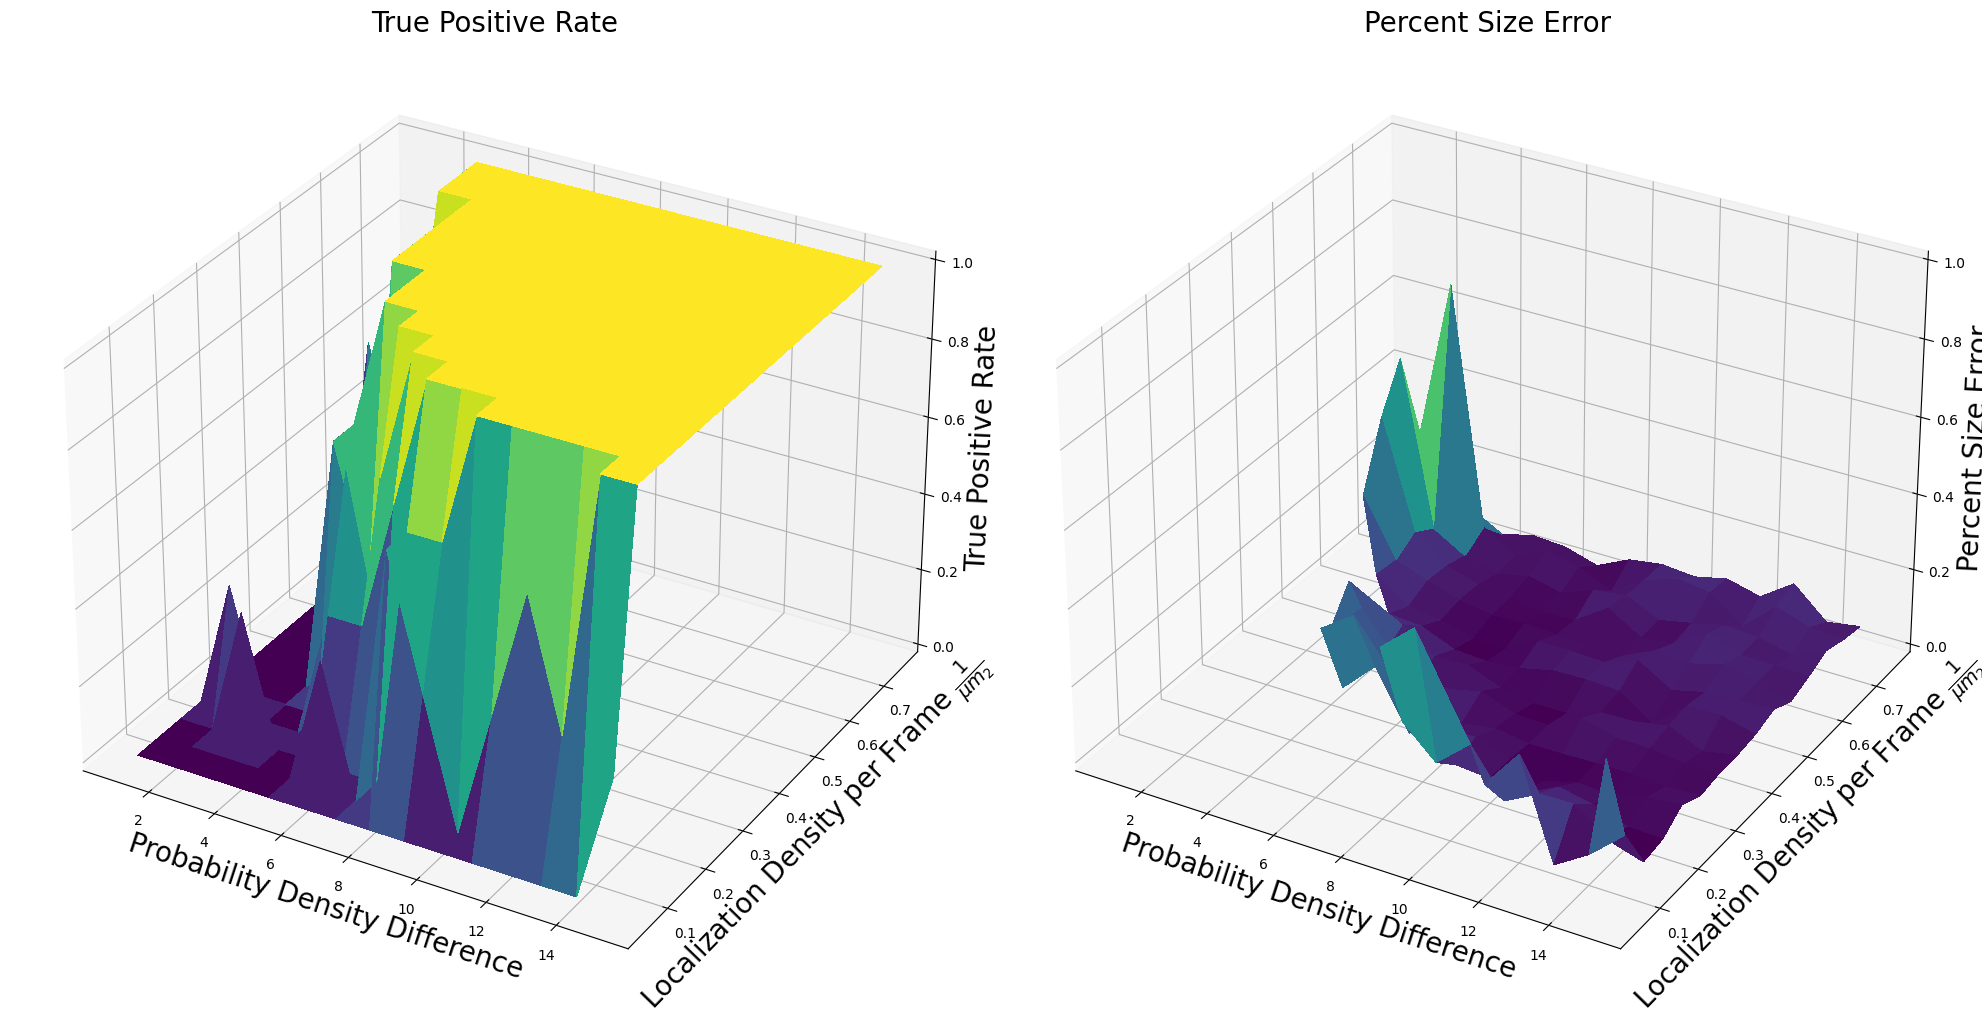

In [344]:
#okay lets plot the results of threshold = 8.5e2 like we did before
#lets plot the 3D plot of the TP for each track length and density dif by averaging over the repeats
#plot the center and scale error too
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0],projection='3d')
ax3 = fig.add_subplot(gs[0, 1],projection='3d')

#lets plot the TP
X, Y = np.meshgrid(density_dif, track_lengths/4/500.)
Z = np.mean(TP_collection_ID_same_size_2_density_length_threshold[:,:,0,:],axis=2)
surf = ax1.plot_surface(X, Y, Z,linewidth=0, antialiased=False,cmap="viridis")
ax1.set_xlabel("Probability Density Difference",fontsize=20)
ax1.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax1.set_zlabel("True Positive Rate",fontsize=20)
ax1.set_title("True Positive Rate",fontsize=20)
ax1.set_zlim(0,1)

#lets plot the scale error
X, Y = np.meshgrid(density_dif, track_lengths/4/500.)
Z = np.nanmean(np.nanmean(scale_error_collection_ID_same_size_2_density_length_threshold[:,:,0,:],axis=2),axis=2)
surf = ax3.plot_surface(X, Y, Z,linewidth=0, antialiased=False,cmap="viridis")
ax3.set_xlabel("Probability Density Difference",fontsize=20)
ax3.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax3.set_zlabel("Percent Size Error",fontsize=20)
ax3.set_title("Percent Size Error",fontsize=20)
ax3.set_zlim(0,1)
plt.tight_layout()


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_39396/2283058129.py:19: RuntimeWarning: Mean of empty slice
  Z = np.nanmean(np.nanmean(scale_error_collection_ID_same_size_2_density_length_threshold[:,:,1,:],axis=2),axis=2)


<Figure size 640x480 with 0 Axes>

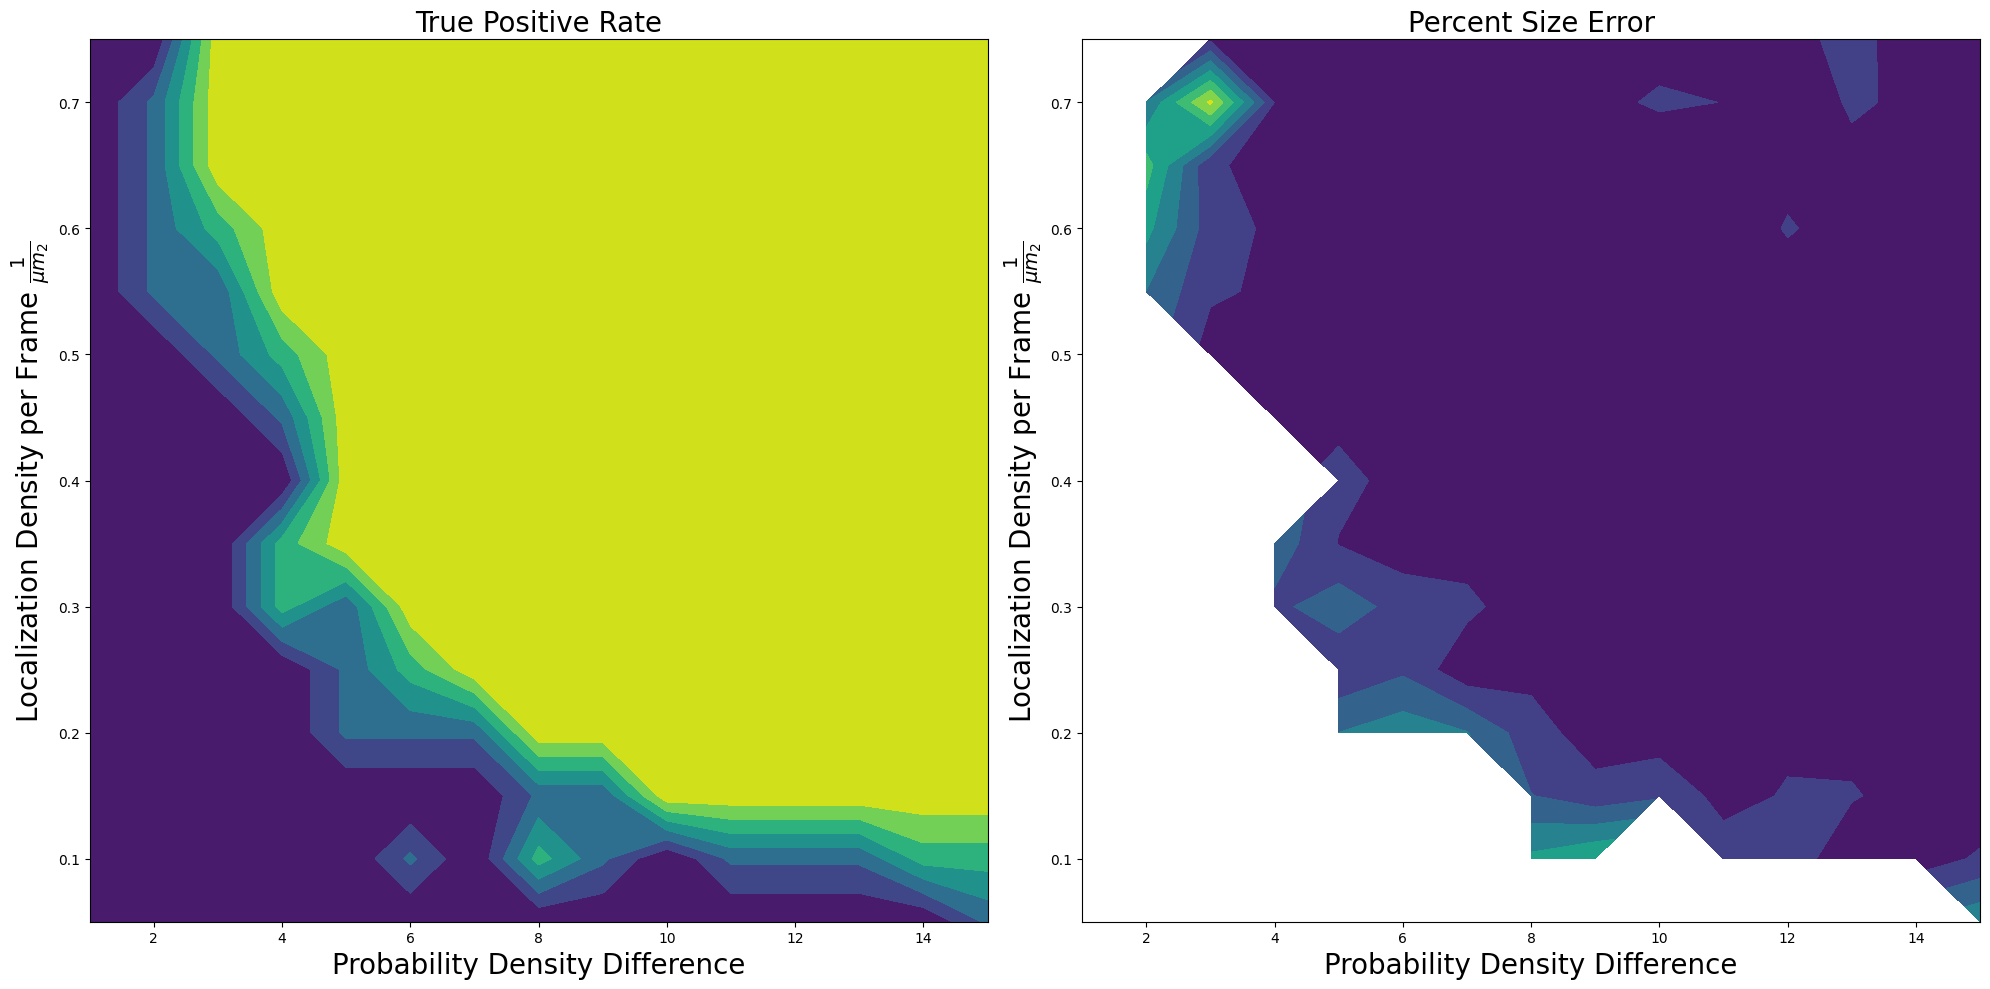

In [345]:
plt.clf()
#replot these as a 2D contour plot
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])

#lets plot the TP
X, Y = np.meshgrid(density_dif, track_lengths/4/500.)
Z = np.mean(TP_collection_ID_same_size_2_density_length_threshold[:,:,1,:],axis=2)
CS = ax1.contourf(X, Y, Z,cmap="viridis")
ax1.set_xlabel("Probability Density Difference",fontsize=20)
ax1.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax1.set_title("True Positive Rate",fontsize=20)
#ax1.clabel(CS, inline=1, fontsize=10)

#lets plot the scale error
X, Y = np.meshgrid(density_dif, track_lengths/4/500.)
Z = np.nanmean(np.nanmean(scale_error_collection_ID_same_size_2_density_length_threshold[:,:,1,:],axis=2),axis=2)
CS = ax3.contourf(X, Y, Z,cmap="viridis")
ax3.set_xlabel("Probability Density Difference",fontsize=20)
ax3.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax3.set_title("Percent Size Error",fontsize=20)
#ax3.clabel(CS, inline=1, fontsize=10)



plt.tight_layout()

plt.show()

In [11]:
#lets make a utility function to create all points in the cell using the points per frame dict
def create_all_points(points_per_frame_dict):
    all_points = []
    for frame in points_per_frame_dict.keys():
        #only take the x,y coordinates
        if len(points_per_frame_dict[frame])>0:
            all_points.extend(np.array(points_per_frame_dict[frame])[:,0:2])
    return np.array(all_points)

#lets make a utility function to perform DBSCAN on the points per frame dict using supplied parameters D and minPts.
def perform_DBSCAN(points_per_frame_dict,D,minPts,convert=False):
    if convert == True:
        all_points = create_all_points(points_per_frame_dict)
    else:
        all_points = points_per_frame_dict
    db = DBSCAN(eps=D, min_samples=minPts).fit(all_points)
    labels = db.labels_
    return labels

In [360]:
#as a test lets perform this again for the same conditions but using DBSCAN as the blob detector
#lets set up a range of lengths of tracks to simulate
track_lengths = np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200])
repeats = 1
D_DBSCAN = 0.6
minPts_DBSCAN = 5
density_dif = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
#we are going to use ID_same_size_1_sim as the initial dict

#collection of TP and FP and center and scale errors
TP_collection_ID_same_size_2_density_length_DBSCAN = np.zeros((len(track_lengths),len(density_dif),repeats))
FP_collection_ID_same_size_2_density_length_DBSCAN = np.zeros((len(track_lengths),len(density_dif),repeats))
center_error_collection_ID_same_size_2_density_length_DBSCAN = np.zeros((len(track_lengths),len(density_dif),repeats,len(ID_same_size_1_sim["initial_centers"])))
scale_error_collection_ID_same_size_2_density_length_DBSCAN = np.zeros((len(track_lengths),len(density_dif),repeats,len(ID_same_size_1_sim["initial_centers"])))

for i in range(len(track_lengths)):
    for j in range(len(density_dif)):
        for k in range(repeats):
            #okay lets make the initial dict
            ID_same_size_1_sim_LD, cell_parms_1_sim_LD, global_sim_params_1_sim_LD = utility_params(ID_same_size_1,track_lengths[i],1,density_dif[j],"constant",1.)
            #lets simulate the data
            cell_sim_1_sim_LD = simulate_cells.Simulate_cells(cell_parms_1_sim_LD,global_sim_params_1_sim_LD)
            a_1_sim_LD = cell_sim_1_sim_LD.get_cell()
            
            #convert the points_perf_frame dict to a list of points
            points_per_frame_dict = create_all_points(a_1_sim_LD["points_per_frame"])
            #perform DBSCAN
            labels = perform_DBSCAN(points_per_frame_dict,D_DBSCAN,minPts_DBSCAN,convert=False)
            #number of clusters
            num_clusters = len(np.unique(labels))-1

            cluster_scales = []
            cluster_centers = []
            for cluster in np.unique(labels):
                if cluster != -1:
                    circle_made = smallestenclosingcircle.make_circle(points_per_frame_dict[labels==cluster])
                    cluster_scales.append(circle_made[2])
                    cluster_centers.append(circle_made[0:2])
            cluster_scales = np.array(cluster_scales)
            cluster_centers = np.array(cluster_centers)
            #lets get the true positives and errors
            #find the true centers and scales
            true_centers = np.array(ID_same_size_1_sim_LD["initial_centers"])
            true_scale = np.array(ID_same_size_1_sim_LD["initial_scale"])
            true_center_TP_center_error = np.ones(len(true_centers))*np.nan
            true_center_TP_scale_error = np.ones(len(true_centers))*np.nan

            if num_clusters > 0:
                for l in range(len(true_centers)):
                    for m in range(len(cluster_centers)):
                        if np.linalg.norm(true_centers[l]-cluster_centers[m])<1.:
                            if true_center_TP_center_error[l] > np.linalg.norm(true_centers[l]-cluster_centers[m]) or np.isnan(true_center_TP_center_error[l]):
                                true_center_TP_center_error[l] = np.linalg.norm(true_centers[l]-cluster_centers[m])
                                true_center_TP_scale_error[l] = np.abs(true_scale[l]-cluster_scales[m])/true_scale[l]
            false_positives = len(cluster_centers)-len(true_center_TP_center_error[~np.isnan(true_center_TP_center_error)])
            #get the true positives
            true_positive_num = len(true_center_TP_center_error[~np.isnan(true_center_TP_center_error)])

            
            #lets store the results
            TP_collection_ID_same_size_2_density_length_DBSCAN[i,j,k] = true_positive_num
            FP_collection_ID_same_size_2_density_length_DBSCAN[i,j,k] = false_positives
            center_error_collection_ID_same_size_2_density_length_DBSCAN[i,j,k,:] = true_center_TP_center_error
            scale_error_collection_ID_same_size_2_density_length_DBSCAN[i,j,k,:] = true_center_TP_scale_error
        #print updates
        print("Completed: ",i+1,"/",len(track_lengths)," ",j+1,"/",len(density_dif))
        

                    






    


[[100 100]]
[]
Completed:  1 / 12   1 / 15
[[100 100]]
[]
Completed:  1 / 12   2 / 15
[[100 100]]
[]
Completed:  1 / 12   3 / 15
[[100 100]]
[]
Completed:  1 / 12   4 / 15
[[100 100]]
[]
Completed:  1 / 12   5 / 15
[[100 100]]
[]
Completed:  1 / 12   6 / 15
[[100 100]]
[]
Completed:  1 / 12   7 / 15
[[100 100]]
[[ 99.55599339 101.32910066]]
Completed:  1 / 12   8 / 15
[[100 100]]
[]
Completed:  1 / 12   9 / 15
[[100 100]]
[]
Completed:  1 / 12   10 / 15
[[100 100]]
[[100.92127989  99.37725127]]
Completed:  1 / 12   11 / 15
[[100 100]]
[[100.30256762  99.46711717]]
Completed:  1 / 12   12 / 15
[[100 100]]
[[99.27159964 99.33630142]]
Completed:  1 / 12   13 / 15
[[100 100]]
[[100.64656416 100.20739595]
 [ 98.81654531 100.723461  ]]
Completed:  1 / 12   14 / 15
[[100 100]]
[[100.62002053  98.62848396]
 [100.71814102 101.27127838]]
Completed:  1 / 12   15 / 15
[[100 100]]
[]
Completed:  2 / 12   1 / 15
[[100 100]]
[]
Completed:  2 / 12   2 / 15
[[100 100]]
[[ 99.45279386 100.50841581]]
Com

In [361]:
#lets save this to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix
SAVE = False
if SAVE == True:
    DBSCAN_file_data = [TP_collection_ID_same_size_2_density_length_DBSCAN,FP_collection_ID_same_size_2_density_length_DBSCAN,center_error_collection_ID_same_size_2_density_length_DBSCAN,scale_error_collection_ID_same_size_2_density_length_DBSCAN]
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix/DBSCAN_file_data.pkl', 'wb') as f:
        pickle.dump(DBSCAN_file_data, f)


/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_39396/1314609074.py:20: RuntimeWarning: Mean of empty slice
  Z = np.nanmean(np.nanmean(scale_error_collection_ID_same_size_2_density_length_DBSCAN,axis=2),axis=2)


(0.0, 1.0)

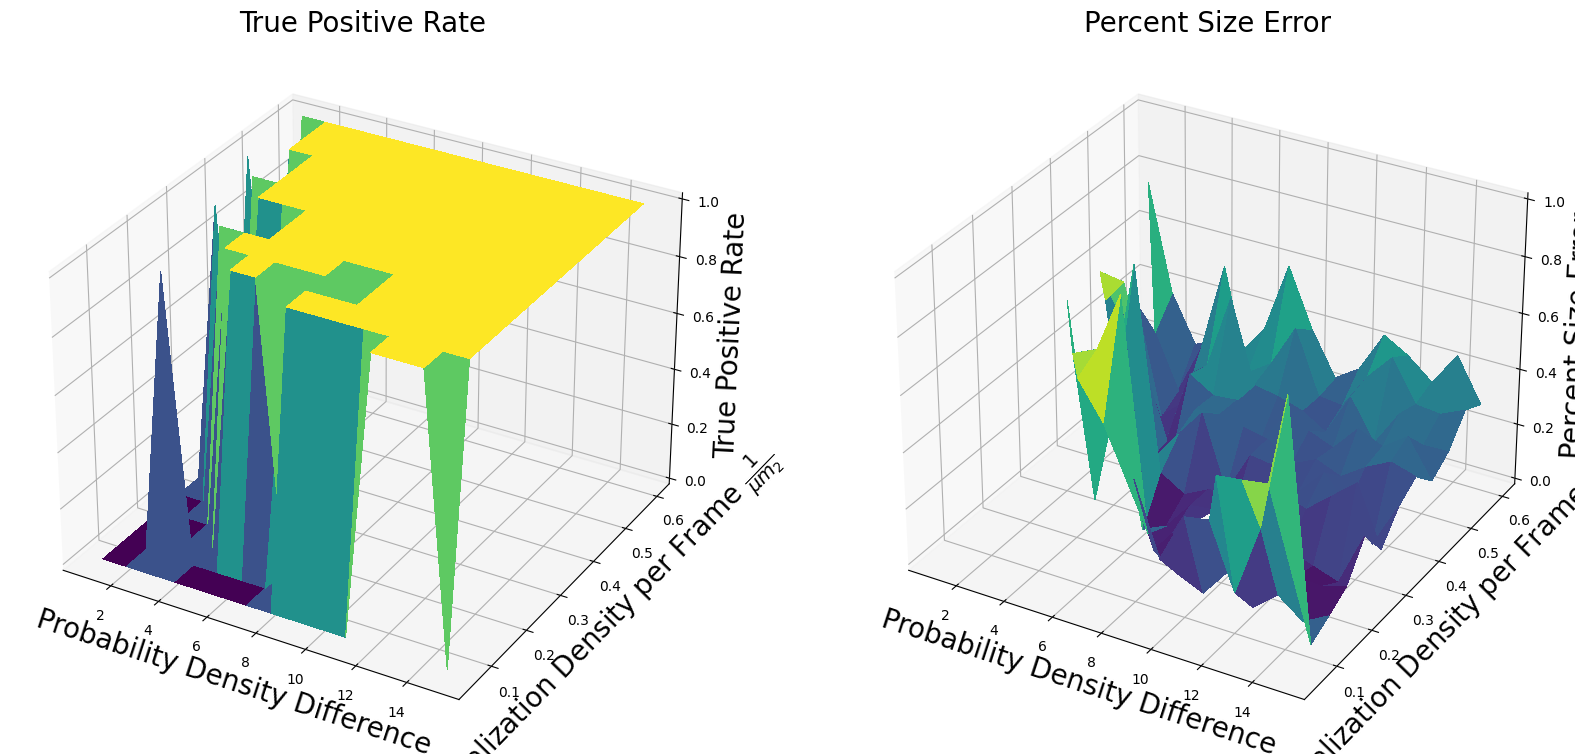

In [363]:
#lets plot the 3D plot of the TP for each track length and density dif by averaging over the repeats
#plot the center and scale error too
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0],projection='3d')
ax3 = fig.add_subplot(gs[0, 1],projection='3d')

#lets plot the TP
X, Y = np.meshgrid(density_dif, track_lengths/4/500.)
Z = np.mean(TP_collection_ID_same_size_2_density_length_DBSCAN,axis=2)
surf = ax1.plot_surface(X, Y, Z,linewidth=0, antialiased=False,cmap="viridis")
ax1.set_xlabel("Probability Density Difference",fontsize=20)
ax1.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax1.set_zlabel("True Positive Rate",fontsize=20)
ax1.set_title("True Positive Rate",fontsize=20)


#lets plot the scale error
X, Y = np.meshgrid(density_dif, track_lengths/4/500.)
Z = np.nanmean(np.nanmean(scale_error_collection_ID_same_size_2_density_length_DBSCAN,axis=2),axis=2)
surf = ax3.plot_surface(X, Y, Z,linewidth=0, antialiased=False,cmap="viridis")
ax3.set_xlabel("Probability Density Difference",fontsize=20)
ax3.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax3.set_zlabel("Percent Size Error",fontsize=20)
ax3.set_title("Percent Size Error",fontsize=20)
ax3.set_zlim(0,1)



In [12]:
#make a utility function for DBSCAN TP and FP and center and scale errors
def DBSCAN_TP_FP_center_scale_error(ID_dict,points_per_frame,D,minPts,convert=False,threshold=1.):
    #convert the points_perf_frame dict to a list of points
    if convert == True:
        all_points = create_all_points(points_per_frame)
    else:
        all_points = points_per_frame
    #perform DBSCAN
    labels = perform_DBSCAN(all_points,D,minPts,convert=False)
    #number of clusters
    num_clusters = len(np.unique(labels))-1

    cluster_scales = []
    cluster_centers = []
    for cluster in np.unique(labels):
        if cluster != -1:
            circle_made = smallestenclosingcircle.make_circle(points_per_frame[labels==cluster])
            cluster_scales.append(circle_made[2])
            cluster_centers.append(circle_made[0:2])
    cluster_scales = np.array(cluster_scales)
    cluster_centers = np.array(cluster_centers)
    #lets get the true positives and errors
    #find the true centers and scales
    true_centers = np.array(ID_dict["initial_centers"])
    true_scale = np.array(ID_dict["initial_scale"])
    true_center_TP_center_error = np.ones(len(true_centers))*np.nan
    true_center_TP_scale_error = np.ones(len(true_centers))*np.nan

    if num_clusters > 0:
        for l in range(len(true_centers)):
            for m in range(len(cluster_centers)):
                if np.linalg.norm(true_centers[l]-cluster_centers[m])<threshold:
                    if true_center_TP_center_error[l] > np.linalg.norm(true_centers[l]-cluster_centers[m]) or np.isnan(true_center_TP_center_error[l]):
                        true_center_TP_center_error[l] = np.linalg.norm(true_centers[l]-cluster_centers[m])
                        true_center_TP_scale_error[l] = np.abs(true_scale[l]-cluster_scales[m])/true_scale[l]
    false_positives = len(cluster_centers)-len(true_center_TP_center_error[~np.isnan(true_center_TP_center_error)])
    #get the true positives
    true_positive_num = len(true_center_TP_center_error[~np.isnan(true_center_TP_center_error)])
    return true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error
    

In [13]:
#okay lets make a sim with a different sized cluster
#lets set up a range of condensates to simulate
ID_same_size_1_1 = {
    "initial_centers":np.array([[100,100]]),
    "initial_scale": np.array([1]),
    "diffusion_coefficient": np.array([0]),
    "hurst_exponent": np.array([0.2])  
}
ID_same_size_1_2 = {
    "initial_centers":np.array([[100,100],[90,95]]),
    "initial_scale": np.array([1,1]),
    "diffusion_coefficient": np.array([0,0]),
    "hurst_exponent": np.array([0.2,0.2])
}
ID_same_size_1_3 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100]]),
    "initial_scale": np.array([1,1,1]),
    "diffusion_coefficient": np.array([0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2])
}
ID_same_size_1_4 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100],[115,95]]),
    "initial_scale": np.array([1,1,1,1]),
    "diffusion_coefficient": np.array([0,0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2,0.2])
}

initial_dict_collection_same_size_1 = [ID_same_size_1_1,ID_same_size_1_2,ID_same_size_1_3,ID_same_size_1_4]



In [14]:
#make a utility function to perfrom the sim for the different threshold changes, track lengths and density dif
def perform_sim_for_diff_thresholds(track_lengths,density_dif,threshold_changes,repeats,initial_dict_used,D_DBSCAN,minPts_DBSCAN):
    #make the collection of TP and FP and center and scale errors
    TP_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats))
    FP_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats))
    center_error_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats,len(initial_dict_used["initial_centers"])))
    scale_error_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats,len(initial_dict_used["initial_centers"])))

    #lets contain the points per frame dict
    points_per_frame_collection = []
    #TP for the scale selection
    TP_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats))
    FP_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats))
    center_error_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats,len(initial_dict_used["initial_centers"])))
    scale_error_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats,len(initial_dict_used["initial_centers"])))
    #lets contain the summed sim maps
    map_collection = np.zeros((len(track_lengths),len(density_dif),repeats,200,200))

    for i in range(len(track_lengths)):
        for j in range(len(density_dif)):
            for k in range(repeats):
                #okay lets make the initial dict
                ID_sim, cell_parms_sim, global_sim_params_sim = utility_params(initial_dict_used,track_lengths[i],1,density_dif[j],"constant",1.)
                #lets simulate the data
                cell_sim = simulate_cells.Simulate_cells(cell_parms_sim,global_sim_params_sim)
                a_sim = cell_sim.get_cell()
                
                #store the points per frame dict
                points_per_frame_collection.append(a_sim["points_per_frame"])
                #store the summed map
                map_collection[i,j,k,:,:] = np.sum(a_sim["map"],axis=0)

                #lets get the points per frame dict
                points_per_frame_dict = create_all_points(a_sim["points_per_frame"])
                #lets perform DBSCAN using the utility function
                DBSCAN_TP,DBSCAN_FP,DBSCAN_center_error,DBSCAN_scale_error = DBSCAN_TP_FP_center_scale_error(ID_sim,points_per_frame_dict,D_DBSCAN,minPts_DBSCAN,convert=False)
                #lets update the collection
                TP_collection_DB[i,j,k] = DBSCAN_TP
                FP_collection_DB[i,j,k] = DBSCAN_FP
                center_error_collection_DB[i,j,k,:] = DBSCAN_center_error
                scale_error_collection_DB[i,j,k,:] = DBSCAN_scale_error

                #lets perform scale selection on the simulated data
                for l in range(len(threshold_changes)):
                    c_sim_LD = scale_utility(img_map = np.sum(a_sim["map"],axis=0),threshold = threshold_changes[l])
                    #lets get the true positives and errors
                    true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error = true_positive_and_erros(ID_sim,c_sim_LD,center_threshold=1)
                    #lets update the collection
                    TP_collection_scale[i,j,l,k] = true_positive_num
                    FP_collection_scale[i,j,l,k] = false_positives
                    center_error_collection_scale[i,j,l,k,:] = true_center_TP_center_error
                    scale_error_collection_scale[i,j,l,k,:] = true_center_TP_scale_error
                #print updates
                print("Completed: ",i+1,"/",len(track_lengths)," ",j+1,"/",len(density_dif)," ",k+1,"/",repeats)
    #make a collection of the TP and FP and center and scale errors for DBSCAN and scale selection
    DBSCAN_collection = [TP_collection_DB,FP_collection_DB,center_error_collection_DB,scale_error_collection_DB]
    scale_collection = [TP_collection_scale,FP_collection_scale,center_error_collection_scale,scale_error_collection_scale]
    return DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection


In [15]:
#remove warnings
import warnings
warnings.filterwarnings("ignore")


In [390]:
#lets set up a range of lengths of tracks to simulate
track_lengths = np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200])
repeats = 3
D_DBSCAN = 0.6
minPts_DBSCAN = 5
density_dif = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
threshold_changes = np.array([8.5e2,9.5e2,1e3])
#we are going to use ID_same_size_1_1 as the initial dict

#lets perform the sim 
DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection = perform_sim_for_diff_thresholds(track_lengths,density_dif,threshold_changes,repeats,ID_same_size_1_1,D_DBSCAN,minPts_DBSCAN)


Completed:  1 / 12   1 / 15   1 / 3
Completed:  1 / 12   1 / 15   2 / 3
Completed:  1 / 12   1 / 15   3 / 3
Completed:  1 / 12   2 / 15   1 / 3
Completed:  1 / 12   2 / 15   2 / 3
Completed:  1 / 12   2 / 15   3 / 3
Completed:  1 / 12   3 / 15   1 / 3
Completed:  1 / 12   3 / 15   2 / 3
Completed:  1 / 12   3 / 15   3 / 3
Completed:  1 / 12   4 / 15   1 / 3
Completed:  1 / 12   4 / 15   2 / 3
Completed:  1 / 12   4 / 15   3 / 3
Completed:  1 / 12   5 / 15   1 / 3
Completed:  1 / 12   5 / 15   2 / 3
Completed:  1 / 12   5 / 15   3 / 3
Completed:  1 / 12   6 / 15   1 / 3
Completed:  1 / 12   6 / 15   2 / 3
Completed:  1 / 12   6 / 15   3 / 3
Completed:  1 / 12   7 / 15   1 / 3
Completed:  1 / 12   7 / 15   2 / 3
Completed:  1 / 12   7 / 15   3 / 3
Completed:  1 / 12   8 / 15   1 / 3
Completed:  1 / 12   8 / 15   2 / 3
Completed:  1 / 12   8 / 15   3 / 3
Completed:  1 / 12   9 / 15   1 / 3
Completed:  1 / 12   9 / 15   2 / 3
Completed:  1 / 12   9 / 15   3 / 3
Completed:  1 / 12   10 / 15

In [391]:
#save the results to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_1pix
SAVE = True
if SAVE == True:
    DBSCAN_scale_file_data = [DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection]
    Param_file = [track_lengths,repeats,D_DBSCAN,minPts_DBSCAN,density_dif,threshold_changes]
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_1pix/DBSCAN_scale_file_data.pkl', 'wb') as f:
        pickle.dump(DBSCAN_scale_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_1pix/Param_file.pkl', 'wb') as f:
        pickle.dump(Param_file, f)


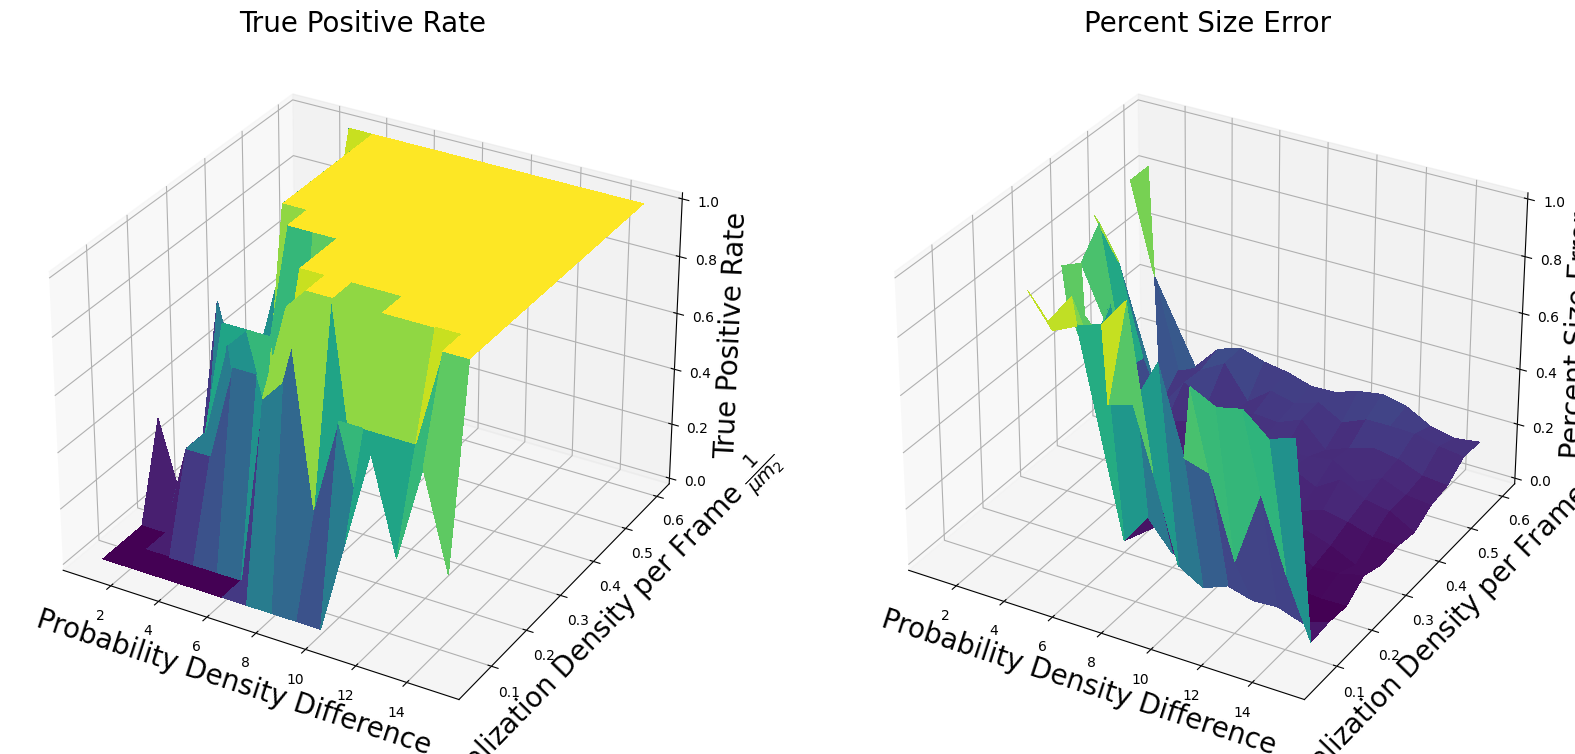

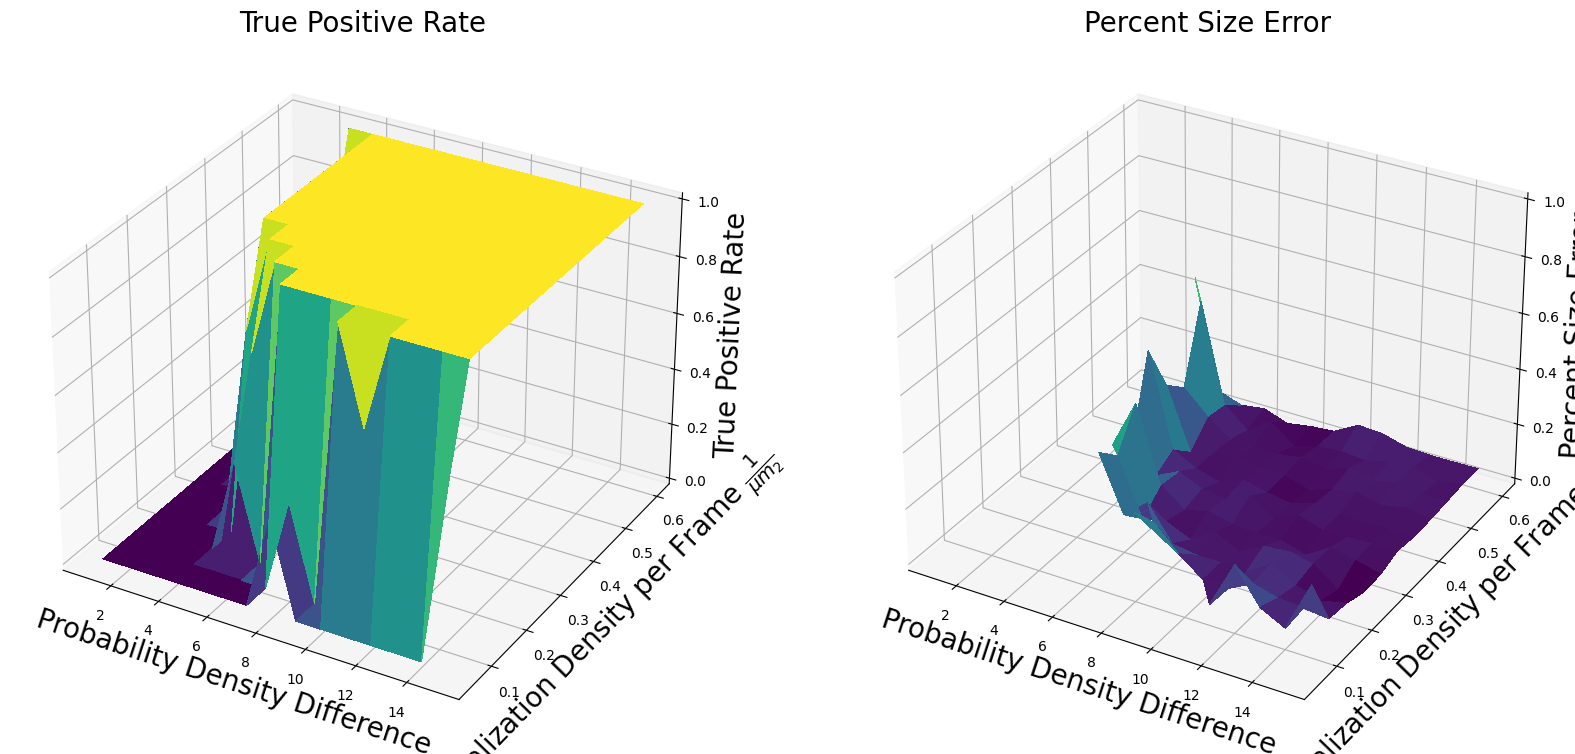

In [409]:
#lets plot the 3D plot of the TP for each track length and density dif by averaging over the repeats
#plot the center and scale error too
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0],projection='3d')
ax3 = fig.add_subplot(gs[0, 1],projection='3d')

#lets plot the TP
X, Y = np.meshgrid(density_dif, track_lengths/4/500.)
Z = np.mean(DBSCAN_collection[0],axis=2)
surf = ax1.plot_surface(X, Y, Z,linewidth=0, antialiased=False,cmap="viridis")
ax1.set_xlabel("Probability Density Difference",fontsize=20)
ax1.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax1.set_zlabel("True Positive Rate",fontsize=20)
ax1.set_title("True Positive Rate",fontsize=20)


#lets plot the scale error
X, Y = np.meshgrid(density_dif, track_lengths/4/500.)
Z = np.nanmean(np.nanmean(DBSCAN_collection[3],axis=2),axis=2)
surf = ax3.plot_surface(X, Y, Z,linewidth=0, antialiased=False,cmap="viridis")
ax3.set_xlabel("Probability Density Difference",fontsize=20)
ax3.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax3.set_zlabel("Percent Size Error",fontsize=20)
ax3.set_title("Percent Size Error",fontsize=20)
ax3.set_zlim(0,1)

plt.show()

#repeat for the scale selection
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0],projection='3d')
ax3 = fig.add_subplot(gs[0, 1],projection='3d')

#lets plot the TP
X, Y = np.meshgrid(density_dif, track_lengths/4/500.)
Z = np.mean(scale_collection[0][:,:,0,:],axis=2)
surf = ax1.plot_surface(X, Y, Z,linewidth=0, antialiased=False,cmap="viridis")
ax1.set_xlabel("Probability Density Difference",fontsize=20)
ax1.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax1.set_zlabel("True Positive Rate",fontsize=20)
ax1.set_title("True Positive Rate",fontsize=20)


#lets plot the scale error
X, Y = np.meshgrid(density_dif, track_lengths/4/500.)
Z = np.nanmean(np.nanmean(scale_collection[3][:,:,2,:],axis=2),axis=2)
surf = ax3.plot_surface(X, Y, Z,linewidth=0, antialiased=False,cmap="viridis")
ax3.set_xlabel("Probability Density Difference",fontsize=20)
ax3.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax3.set_zlabel("Percent Size Error",fontsize=20)
ax3.set_title("Percent Size Error",fontsize=20)
ax3.set_zlim(0,1)

plt.show()


In [400]:
#lets make one for 0.5 size
#okay lets make a sim with a different sized cluster
#lets set up a range of condensates to simulate
ID_same_size_05_1 = {
    "initial_centers":np.array([[100,100]]),
    "initial_scale": np.array([0.5]),
    "diffusion_coefficient": np.array([0]),
    "hurst_exponent": np.array([0.2])  
}
ID_same_size_05_2 = {
    "initial_centers":np.array([[100,100],[90,95]]),
    "initial_scale": np.array([0.5,0.5]),
    "diffusion_coefficient": np.array([0,0]),
    "hurst_exponent": np.array([0.2,0.2])
}
ID_same_size_05_3 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100]]),
    "initial_scale": np.array([0.5,0.5,0.5]),
    "diffusion_coefficient": np.array([0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2])
}
ID_same_size_05_4 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100],[115,95]]),
    "initial_scale": np.array([0.5,0.5,0.5,0.5]),
    "diffusion_coefficient": np.array([0,0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2,0.2])
}

initial_dict_collection_same_size_05 = [ID_same_size_05_1,ID_same_size_05_2,ID_same_size_05_3,ID_same_size_05_4]

#lets set up a range of lengths of tracks to simulate
track_lengths = np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200])
repeats = 3
D_DBSCAN = 0.6
minPts_DBSCAN = 5
density_dif = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
threshold_changes = np.array([8.5e2,9.5e2,1e3])
#we are going to use ID_same_size_1_1 as the initial dict

#lets perform the sim 
DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection = perform_sim_for_diff_thresholds(track_lengths,density_dif,threshold_changes,repeats,ID_same_size_05_1,D_DBSCAN,minPts_DBSCAN)



Completed:  1 / 12   1 / 15   1 / 3
Completed:  1 / 12   1 / 15   2 / 3
Completed:  1 / 12   1 / 15   3 / 3
Completed:  1 / 12   2 / 15   1 / 3
Completed:  1 / 12   2 / 15   2 / 3
Completed:  1 / 12   2 / 15   3 / 3
Completed:  1 / 12   3 / 15   1 / 3
Completed:  1 / 12   3 / 15   2 / 3
Completed:  1 / 12   3 / 15   3 / 3
Completed:  1 / 12   4 / 15   1 / 3
Completed:  1 / 12   4 / 15   2 / 3
Completed:  1 / 12   4 / 15   3 / 3
Completed:  1 / 12   5 / 15   1 / 3
Completed:  1 / 12   5 / 15   2 / 3
Completed:  1 / 12   5 / 15   3 / 3
Completed:  1 / 12   6 / 15   1 / 3
Completed:  1 / 12   6 / 15   2 / 3
Completed:  1 / 12   6 / 15   3 / 3
Completed:  1 / 12   7 / 15   1 / 3
Completed:  1 / 12   7 / 15   2 / 3
Completed:  1 / 12   7 / 15   3 / 3
Completed:  1 / 12   8 / 15   1 / 3
Completed:  1 / 12   8 / 15   2 / 3
Completed:  1 / 12   8 / 15   3 / 3
Completed:  1 / 12   9 / 15   1 / 3
Completed:  1 / 12   9 / 15   2 / 3
Completed:  1 / 12   9 / 15   3 / 3
Completed:  1 / 12   10 / 15

In [401]:
#save the results to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_0.5pix

SAVE = True
if SAVE == True:
    DBSCAN_scale_file_data = [DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection]
    Param_file = [track_lengths,repeats,D_DBSCAN,minPts_DBSCAN,density_dif,threshold_changes]
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_0.5pix/DBSCAN_scale_file_data.pkl', 'wb') as f:
        pickle.dump(DBSCAN_scale_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_0.5pix/Param_file.pkl', 'wb') as f:
        pickle.dump(Param_file, f)
    

In [402]:
#lets make one for 1.5 size
#okay lets make a sim with a different sized cluster
#lets set up a range of condensates to simulate
ID_same_size_15_1 = {
    "initial_centers":np.array([[100,100]]),
    "initial_scale": np.array([1.5]),
    "diffusion_coefficient": np.array([0]),
    "hurst_exponent": np.array([0.2])  
}
ID_same_size_15_2 = {
    "initial_centers":np.array([[100,100],[90,95]]),
    "initial_scale": np.array([1.5,1.5]),
    "diffusion_coefficient": np.array([0,0]),
    "hurst_exponent": np.array([0.2,0.2])
}
ID_same_size_15_3 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100]]),
    "initial_scale": np.array([1.5,1.5,1.5]),
    "diffusion_coefficient": np.array([0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2])
}
ID_same_size_15_4 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100],[115,95]]),
    "initial_scale": np.array([1.5,1.5,1.5,1.5]),
    "diffusion_coefficient": np.array([0,0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2,0.2])
}

initial_dict_collection_same_size_15 = [ID_same_size_15_1,ID_same_size_15_2,ID_same_size_15_3,ID_same_size_15_4]

#lets set up a range of lengths of tracks to simulate
track_lengths = np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200])
repeats = 3
D_DBSCAN = 0.6
minPts_DBSCAN = 5
density_dif = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
threshold_changes = np.array([8.5e2,9.5e2,1e3])
#we are going to use ID_same_size_1_1 as the initial dict

#lets perform the sim 
DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection = perform_sim_for_diff_thresholds(track_lengths,density_dif,threshold_changes,repeats,ID_same_size_15_1,D_DBSCAN,minPts_DBSCAN)



Completed:  1 / 12   1 / 15   1 / 3
Completed:  1 / 12   1 / 15   2 / 3
Completed:  1 / 12   1 / 15   3 / 3
Completed:  1 / 12   2 / 15   1 / 3
Completed:  1 / 12   2 / 15   2 / 3
Completed:  1 / 12   2 / 15   3 / 3
Completed:  1 / 12   3 / 15   1 / 3
Completed:  1 / 12   3 / 15   2 / 3
Completed:  1 / 12   3 / 15   3 / 3
Completed:  1 / 12   4 / 15   1 / 3
Completed:  1 / 12   4 / 15   2 / 3
Completed:  1 / 12   4 / 15   3 / 3
Completed:  1 / 12   5 / 15   1 / 3
Completed:  1 / 12   5 / 15   2 / 3
Completed:  1 / 12   5 / 15   3 / 3
Completed:  1 / 12   6 / 15   1 / 3
Completed:  1 / 12   6 / 15   2 / 3
Completed:  1 / 12   6 / 15   3 / 3
Completed:  1 / 12   7 / 15   1 / 3
Completed:  1 / 12   7 / 15   2 / 3
Completed:  1 / 12   7 / 15   3 / 3
Completed:  1 / 12   8 / 15   1 / 3
Completed:  1 / 12   8 / 15   2 / 3
Completed:  1 / 12   8 / 15   3 / 3
Completed:  1 / 12   9 / 15   1 / 3
Completed:  1 / 12   9 / 15   2 / 3
Completed:  1 / 12   9 / 15   3 / 3
Completed:  1 / 12   10 / 15

In [403]:
#save the results to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_1.5pix

SAVE = True
if SAVE == True:
    DBSCAN_scale_file_data = [DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection]
    Param_file = [track_lengths,repeats,D_DBSCAN,minPts_DBSCAN,density_dif,threshold_changes]
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_1.5pix/DBSCAN_scale_file_data.pkl', 'wb') as f:
        pickle.dump(DBSCAN_scale_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_1.5pix/Param_file.pkl', 'wb') as f:
        pickle.dump(Param_file, f)
    

In [16]:
#lets make one for 1.5 size
#okay lets make a sim with a different sized cluster
#lets set up a range of condensates to simulate
ID_same_size_2_1 = {
    "initial_centers":np.array([[100,100]]),
    "initial_scale": np.array([2]),
    "diffusion_coefficient": np.array([0]),
    "hurst_exponent": np.array([0.2])  
}
ID_same_size_2_2 = {
    "initial_centers":np.array([[100,100],[90,95]]),
    "initial_scale": np.array([2,2]),
    "diffusion_coefficient": np.array([0,0]),
    "hurst_exponent": np.array([0.2,0.2])
}
ID_same_size_2_3 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100]]),
    "initial_scale": np.array([2,2,2]),
    "diffusion_coefficient": np.array([0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2])
}
ID_same_size_2_4 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100],[115,95]]),
    "initial_scale": np.array([2,2,2,2]),
    "diffusion_coefficient": np.array([0,0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2,0.2])
}

initial_dict_collection_same_size_2 = [ID_same_size_2_1,ID_same_size_2_2,ID_same_size_2_3,ID_same_size_2_4]

#lets set up a range of lengths of tracks to simulate
track_lengths = np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200])
repeats = 3
D_DBSCAN = 0.6
minPts_DBSCAN = 5
density_dif = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
threshold_changes = np.array([8.5e2,9.5e2,1e3])
#we are going to use ID_same_size_1_1 as the initial dict

#lets perform the sim 
DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection = perform_sim_for_diff_thresholds(track_lengths,density_dif,threshold_changes,repeats,ID_same_size_2_1,D_DBSCAN,minPts_DBSCAN)



Completed:  1 / 12   1 / 15   1 / 3
Completed:  1 / 12   1 / 15   2 / 3
Completed:  1 / 12   1 / 15   3 / 3
Completed:  1 / 12   2 / 15   1 / 3
Completed:  1 / 12   2 / 15   2 / 3
Completed:  1 / 12   2 / 15   3 / 3
Completed:  1 / 12   3 / 15   1 / 3
Completed:  1 / 12   3 / 15   2 / 3
Completed:  1 / 12   3 / 15   3 / 3
Completed:  1 / 12   4 / 15   1 / 3
Completed:  1 / 12   4 / 15   2 / 3
Completed:  1 / 12   4 / 15   3 / 3
Completed:  1 / 12   5 / 15   1 / 3
Completed:  1 / 12   5 / 15   2 / 3
Completed:  1 / 12   5 / 15   3 / 3
Completed:  1 / 12   6 / 15   1 / 3
Completed:  1 / 12   6 / 15   2 / 3
Completed:  1 / 12   6 / 15   3 / 3
Completed:  1 / 12   7 / 15   1 / 3
Completed:  1 / 12   7 / 15   2 / 3
Completed:  1 / 12   7 / 15   3 / 3
Completed:  1 / 12   8 / 15   1 / 3
Completed:  1 / 12   8 / 15   2 / 3
Completed:  1 / 12   8 / 15   3 / 3
Completed:  1 / 12   9 / 15   1 / 3
Completed:  1 / 12   9 / 15   2 / 3
Completed:  1 / 12   9 / 15   3 / 3
Completed:  1 / 12   10 / 15

In [18]:
#save the results to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix
import pickle
SAVE = True
if SAVE == True:
    DBSCAN_scale_file_data = [DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection]
    Param_file = [track_lengths,repeats,D_DBSCAN,minPts_DBSCAN,density_dif,threshold_changes]
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix/DBSCAN_scale_file_data.pkl', 'wb') as f:
        pickle.dump(DBSCAN_scale_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix/Param_file.pkl', 'wb') as f:
        pickle.dump(Param_file, f)
    

In [404]:
#lets make one for 2.5 size
#okay lets make a sim with a different sized cluster
#lets set up a range of condensates to simulate
ID_same_size_25_1 = {
    "initial_centers":np.array([[100,100]]),
    "initial_scale": np.array([2.5]),
    "diffusion_coefficient": np.array([0]),
    "hurst_exponent": np.array([0.2])  
}
ID_same_size_25_2 = {
    "initial_centers":np.array([[100,100],[90,95]]),
    "initial_scale": np.array([2.5,2.5]),
    "diffusion_coefficient": np.array([0,0]),
    "hurst_exponent": np.array([0.2,0.2])
}
ID_same_size_25_3 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100]]),
    "initial_scale": np.array([2.5,2.5,2.5]),
    "diffusion_coefficient": np.array([0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2])
}
ID_same_size_25_4 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100],[115,95]]),
    "initial_scale": np.array([2.5,2.5,2.5,2.5]),
    "diffusion_coefficient": np.array([0,0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2,0.2])
}

initial_dict_collection_same_size_25 = [ID_same_size_25_1,ID_same_size_25_2,ID_same_size_25_3,ID_same_size_25_4]

#lets set up a range of lengths of tracks to simulate
track_lengths = np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200])
repeats = 3
D_DBSCAN = 0.6
minPts_DBSCAN = 5
density_dif = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
threshold_changes = np.array([8.5e2,9.5e2,1e3])
#we are going to use ID_same_size_1_1 as the initial dict

#lets perform the sim 
DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection = perform_sim_for_diff_thresholds(track_lengths,density_dif,threshold_changes,repeats,ID_same_size_25_1,D_DBSCAN,minPts_DBSCAN)



Completed:  1 / 12   1 / 15   1 / 3
Completed:  1 / 12   1 / 15   2 / 3
Completed:  1 / 12   1 / 15   3 / 3
Completed:  1 / 12   2 / 15   1 / 3
Completed:  1 / 12   2 / 15   2 / 3
Completed:  1 / 12   2 / 15   3 / 3
Completed:  1 / 12   3 / 15   1 / 3
Completed:  1 / 12   3 / 15   2 / 3
Completed:  1 / 12   3 / 15   3 / 3
Completed:  1 / 12   4 / 15   1 / 3
Completed:  1 / 12   4 / 15   2 / 3
Completed:  1 / 12   4 / 15   3 / 3
Completed:  1 / 12   5 / 15   1 / 3
Completed:  1 / 12   5 / 15   2 / 3
Completed:  1 / 12   5 / 15   3 / 3
Completed:  1 / 12   6 / 15   1 / 3
Completed:  1 / 12   6 / 15   2 / 3
Completed:  1 / 12   6 / 15   3 / 3
Completed:  1 / 12   7 / 15   1 / 3
Completed:  1 / 12   7 / 15   2 / 3
Completed:  1 / 12   7 / 15   3 / 3
Completed:  1 / 12   8 / 15   1 / 3
Completed:  1 / 12   8 / 15   2 / 3
Completed:  1 / 12   8 / 15   3 / 3
Completed:  1 / 12   9 / 15   1 / 3
Completed:  1 / 12   9 / 15   2 / 3
Completed:  1 / 12   9 / 15   3 / 3
Completed:  1 / 12   10 / 15

In [405]:
#save the results to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix

SAVE = True
if SAVE == True:
    DBSCAN_scale_file_data = [DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection]
    Param_file = [track_lengths,repeats,D_DBSCAN,minPts_DBSCAN,density_dif,threshold_changes]
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/DBSCAN_scale_file_data.pkl', 'wb') as f:
        pickle.dump(DBSCAN_scale_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/Param_file.pkl', 'wb') as f:
        pickle.dump(Param_file, f)


In [406]:
#lets make one for 3 size
#okay lets make a sim with a different sized cluster
#lets set up a range of condensates to simulate
ID_same_size_3_1 = {
    "initial_centers":np.array([[100,100]]),
    "initial_scale": np.array([3]),
    "diffusion_coefficient": np.array([0]),
    "hurst_exponent": np.array([0.2])  
}
ID_same_size_3_2 = {
    "initial_centers":np.array([[100,100],[90,95]]),
    "initial_scale": np.array([3,3]),
    "diffusion_coefficient": np.array([0,0]),
    "hurst_exponent": np.array([0.2,0.2])
}
ID_same_size_3_3 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100]]),
    "initial_scale": np.array([3,3,3]),
    "diffusion_coefficient": np.array([0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2])
}
ID_same_size_3_4 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100],[115,95]]),
    "initial_scale": np.array([3,3,3,3]),
    "diffusion_coefficient": np.array([0,0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2,0.2])
}

initial_dict_collection_same_size_3 = [ID_same_size_3_1,ID_same_size_3_2,ID_same_size_3_3,ID_same_size_3_4]

#lets set up a range of lengths of tracks to simulate
track_lengths = np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200])
repeats = 3
D_DBSCAN = 0.6
minPts_DBSCAN = 5
density_dif = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
threshold_changes = np.array([8.5e2,9.5e2,1e3])
#we are going to use ID_same_size_1_1 as the initial dict

#lets perform the sim 
DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection = perform_sim_for_diff_thresholds(track_lengths,density_dif,threshold_changes,repeats,ID_same_size_3_1,D_DBSCAN,minPts_DBSCAN)



Completed:  1 / 12   1 / 15   1 / 3
Completed:  1 / 12   1 / 15   2 / 3
Completed:  1 / 12   1 / 15   3 / 3
Completed:  1 / 12   2 / 15   1 / 3
Completed:  1 / 12   2 / 15   2 / 3
Completed:  1 / 12   2 / 15   3 / 3
Completed:  1 / 12   3 / 15   1 / 3
Completed:  1 / 12   3 / 15   2 / 3
Completed:  1 / 12   3 / 15   3 / 3
Completed:  1 / 12   4 / 15   1 / 3
Completed:  1 / 12   4 / 15   2 / 3
Completed:  1 / 12   4 / 15   3 / 3
Completed:  1 / 12   5 / 15   1 / 3
Completed:  1 / 12   5 / 15   2 / 3
Completed:  1 / 12   5 / 15   3 / 3
Completed:  1 / 12   6 / 15   1 / 3
Completed:  1 / 12   6 / 15   2 / 3
Completed:  1 / 12   6 / 15   3 / 3
Completed:  1 / 12   7 / 15   1 / 3
Completed:  1 / 12   7 / 15   2 / 3
Completed:  1 / 12   7 / 15   3 / 3
Completed:  1 / 12   8 / 15   1 / 3
Completed:  1 / 12   8 / 15   2 / 3
Completed:  1 / 12   8 / 15   3 / 3
Completed:  1 / 12   9 / 15   1 / 3
Completed:  1 / 12   9 / 15   2 / 3
Completed:  1 / 12   9 / 15   3 / 3
Completed:  1 / 12   10 / 15

In [407]:
#save the results to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_3pix

SAVE = True
if SAVE == True:
    DBSCAN_scale_file_data = [DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection]
    Param_file = [track_lengths,repeats,D_DBSCAN,minPts_DBSCAN,density_dif,threshold_changes]
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_3pix/DBSCAN_scale_file_data.pkl', 'wb') as f:
        pickle.dump(DBSCAN_scale_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_3pix/Param_file.pkl', 'wb') as f:
        pickle.dump(Param_file, f)
    


In [410]:
#lets make one for 2.5 size for 2 clusters
#okay lets make a sim with a different sized cluster
#lets set up a range of condensates to simulate


#lets set up a range of lengths of tracks to simulate
track_lengths = np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200])
repeats = 3
D_DBSCAN = 0.6
minPts_DBSCAN = 5
density_dif = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
threshold_changes = np.array([8.5e2,9.5e2,1e3])
#we are going to use ID_same_size_1_1 as the initial dict

#lets perform the sim 
DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection = perform_sim_for_diff_thresholds(track_lengths,density_dif,threshold_changes,repeats,ID_same_size_25_2,D_DBSCAN,minPts_DBSCAN)



Completed:  1 / 12   1 / 15   1 / 3
Completed:  1 / 12   1 / 15   2 / 3
Completed:  1 / 12   1 / 15   3 / 3
Completed:  1 / 12   2 / 15   1 / 3
Completed:  1 / 12   2 / 15   2 / 3
Completed:  1 / 12   2 / 15   3 / 3
Completed:  1 / 12   3 / 15   1 / 3
Completed:  1 / 12   3 / 15   2 / 3
Completed:  1 / 12   3 / 15   3 / 3
Completed:  1 / 12   4 / 15   1 / 3
Completed:  1 / 12   4 / 15   2 / 3
Completed:  1 / 12   4 / 15   3 / 3
Completed:  1 / 12   5 / 15   1 / 3
Completed:  1 / 12   5 / 15   2 / 3
Completed:  1 / 12   5 / 15   3 / 3
Completed:  1 / 12   6 / 15   1 / 3
Completed:  1 / 12   6 / 15   2 / 3
Completed:  1 / 12   6 / 15   3 / 3
Completed:  1 / 12   7 / 15   1 / 3
Completed:  1 / 12   7 / 15   2 / 3
Completed:  1 / 12   7 / 15   3 / 3
Completed:  1 / 12   8 / 15   1 / 3
Completed:  1 / 12   8 / 15   2 / 3
Completed:  1 / 12   8 / 15   3 / 3
Completed:  1 / 12   9 / 15   1 / 3
Completed:  1 / 12   9 / 15   2 / 3
Completed:  1 / 12   9 / 15   3 / 3
Completed:  1 / 12   10 / 15

In [411]:
#save the results to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/2_clusters

SAVE = True
if SAVE == True:
    DBSCAN_scale_file_data = [DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection]
    Param_file = [track_lengths,repeats,D_DBSCAN,minPts_DBSCAN,density_dif,threshold_changes]
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/2_clusters/DBSCAN_scale_file_data.pkl', 'wb') as f:
        pickle.dump(DBSCAN_scale_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/2_clusters/Param_file.pkl', 'wb') as f:
        pickle.dump(Param_file, f)



In [412]:
#lets make one for 2.5 size for 3 clusters
#okay lets make a sim with a different sized cluster
#lets set up a range of condensates to simulate


#lets set up a range of lengths of tracks to simulate
track_lengths = np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200])
repeats = 3
D_DBSCAN = 0.6
minPts_DBSCAN = 5
density_dif = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
threshold_changes = np.array([8.5e2,9.5e2,1e3])
#we are going to use ID_same_size_1_1 as the initial dict

#lets perform the sim 
DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection = perform_sim_for_diff_thresholds(track_lengths,density_dif,threshold_changes,repeats,ID_same_size_25_3,D_DBSCAN,minPts_DBSCAN)


Completed:  1 / 12   1 / 15   1 / 3
Completed:  1 / 12   1 / 15   2 / 3
Completed:  1 / 12   1 / 15   3 / 3
Completed:  1 / 12   2 / 15   1 / 3
Completed:  1 / 12   2 / 15   2 / 3
Completed:  1 / 12   2 / 15   3 / 3
Completed:  1 / 12   3 / 15   1 / 3
Completed:  1 / 12   3 / 15   2 / 3
Completed:  1 / 12   3 / 15   3 / 3
Completed:  1 / 12   4 / 15   1 / 3
Completed:  1 / 12   4 / 15   2 / 3
Completed:  1 / 12   4 / 15   3 / 3
Completed:  1 / 12   5 / 15   1 / 3
Completed:  1 / 12   5 / 15   2 / 3
Completed:  1 / 12   5 / 15   3 / 3
Completed:  1 / 12   6 / 15   1 / 3
Completed:  1 / 12   6 / 15   2 / 3
Completed:  1 / 12   6 / 15   3 / 3
Completed:  1 / 12   7 / 15   1 / 3
Completed:  1 / 12   7 / 15   2 / 3
Completed:  1 / 12   7 / 15   3 / 3
Completed:  1 / 12   8 / 15   1 / 3
Completed:  1 / 12   8 / 15   2 / 3
Completed:  1 / 12   8 / 15   3 / 3
Completed:  1 / 12   9 / 15   1 / 3
Completed:  1 / 12   9 / 15   2 / 3
Completed:  1 / 12   9 / 15   3 / 3
Completed:  1 / 12   10 / 15

In [413]:
#save the results to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/3_clusters

SAVE = True
if SAVE == True:
    DBSCAN_scale_file_data = [DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection]
    Param_file = [track_lengths,repeats,D_DBSCAN,minPts_DBSCAN,density_dif,threshold_changes]
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/3_clusters/DBSCAN_scale_file_data.pkl', 'wb') as f:
        pickle.dump(DBSCAN_scale_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/3_clusters/Param_file.pkl', 'wb') as f:
        pickle.dump(Param_file, f)



In [414]:
#lets make one for 2.5 size for 4 clusters
#okay lets make a sim with a different sized cluster
#lets set up a range of condensates to simulate


#lets set up a range of lengths of tracks to simulate
track_lengths = np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200])
repeats = 3
D_DBSCAN = 0.6
minPts_DBSCAN = 5
density_dif = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
threshold_changes = np.array([8.5e2,9.5e2,1e3])
#we are going to use ID_same_size_1_1 as the initial dict

#lets perform the sim 
DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection = perform_sim_for_diff_thresholds(track_lengths,density_dif,threshold_changes,repeats,ID_same_size_25_4,D_DBSCAN,minPts_DBSCAN)


Completed:  1 / 12   1 / 15   1 / 3
Completed:  1 / 12   1 / 15   2 / 3
Completed:  1 / 12   1 / 15   3 / 3
Completed:  1 / 12   2 / 15   1 / 3
Completed:  1 / 12   2 / 15   2 / 3
Completed:  1 / 12   2 / 15   3 / 3
Completed:  1 / 12   3 / 15   1 / 3
Completed:  1 / 12   3 / 15   2 / 3
Completed:  1 / 12   3 / 15   3 / 3
Completed:  1 / 12   4 / 15   1 / 3
Completed:  1 / 12   4 / 15   2 / 3
Completed:  1 / 12   4 / 15   3 / 3
Completed:  1 / 12   5 / 15   1 / 3
Completed:  1 / 12   5 / 15   2 / 3
Completed:  1 / 12   5 / 15   3 / 3
Completed:  1 / 12   6 / 15   1 / 3
Completed:  1 / 12   6 / 15   2 / 3
Completed:  1 / 12   6 / 15   3 / 3
Completed:  1 / 12   7 / 15   1 / 3
Completed:  1 / 12   7 / 15   2 / 3
Completed:  1 / 12   7 / 15   3 / 3
Completed:  1 / 12   8 / 15   1 / 3
Completed:  1 / 12   8 / 15   2 / 3
Completed:  1 / 12   8 / 15   3 / 3
Completed:  1 / 12   9 / 15   1 / 3
Completed:  1 / 12   9 / 15   2 / 3
Completed:  1 / 12   9 / 15   3 / 3
Completed:  1 / 12   10 / 15

In [415]:
#save the results to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/4_clusters

SAVE = True
if SAVE == True:
    DBSCAN_scale_file_data = [DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection]
    Param_file = [track_lengths,repeats,D_DBSCAN,minPts_DBSCAN,density_dif,threshold_changes]
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/4_clusters/DBSCAN_scale_file_data.pkl', 'wb') as f:
        pickle.dump(DBSCAN_scale_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/4_clusters/Param_file.pkl', 'wb') as f:
        pickle.dump(Param_file, f)
        


In [19]:
#make a utility function to perfrom the sim for the different threshold changes, track lengths and density dif
def perform_sim_for_diff_thresholds_plus_sim_cells(track_lengths,density_dif,threshold_changes,repeats,initial_dict_used,D_DBSCAN,minPts_DBSCAN):
    #make the collection of TP and FP and center and scale errors
    TP_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats))
    FP_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats))
    center_error_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats,len(initial_dict_used["initial_centers"])))
    scale_error_collection_DB = np.zeros((len(track_lengths),len(density_dif),repeats,len(initial_dict_used["initial_centers"])))

    #lets contain the points per frame dict
    points_per_frame_collection = []
    sim_cells_collection = []
    #TP for the scale selection
    TP_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats))
    FP_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats))
    center_error_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats,len(initial_dict_used["initial_centers"])))
    scale_error_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats,len(initial_dict_used["initial_centers"])))
    #lets contain the summed sim maps
    map_collection = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats,200,200))

    for i in range(len(track_lengths)):
        for j in range(len(density_dif)):
            for k in range(repeats):
                #okay lets make the initial dict
                ID_sim, cell_parms_sim, global_sim_params_sim = utility_params(initial_dict_used,track_lengths[i],1,density_dif[j],"constant",1.)
                #lets simulate the data
                cell_sim = simulate_cells.Simulate_cells(cell_parms_sim,global_sim_params_sim)
                sim_cells_collection.append(cell_sim)
                a_sim = cell_sim.get_cell()
                
                #store the points per frame dict
                points_per_frame_collection.append(a_sim["points_per_frame"])
                #store the summed map
                map_collection[i,j,k,:,:] = np.sum(a_sim["map"],axis=0)

                #lets get the points per frame dict
                points_per_frame_dict = create_all_points(a_sim["points_per_frame"])
                #lets perform DBSCAN using the utility function
                DBSCAN_TP,DBSCAN_FP,DBSCAN_center_error,DBSCAN_scale_error = DBSCAN_TP_FP_center_scale_error(ID_sim,points_per_frame_dict,D_DBSCAN,minPts_DBSCAN,convert=False)
                #lets update the collection
                TP_collection_DB[i,j,k] = DBSCAN_TP
                FP_collection_DB[i,j,k] = DBSCAN_FP
                center_error_collection_DB[i,j,k,:] = DBSCAN_center_error
                scale_error_collection_DB[i,j,k,:] = DBSCAN_scale_error

                #lets perform scale selection on the simulated data
                for l in range(len(threshold_changes)):
                    c_sim_LD = scale_utility(img_map = np.sum(a_sim["map"],axis=0),threshold = threshold_changes[l])
                    #lets get the true positives and errors
                    true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error = true_positive_and_erros(ID_sim,c_sim_LD,center_threshold=1)
                    #lets update the collection
                    TP_collection_scale[i,j,l,k] = true_positive_num
                    FP_collection_scale[i,j,l,k] = false_positives
                    center_error_collection_scale[i,j,l,k,:] = true_center_TP_center_error
                    scale_error_collection_scale[i,j,l,k,:] = true_center_TP_scale_error
                #print updates
                print("Completed: ",i+1,"/",len(track_lengths)," ",j+1,"/",len(density_dif)," ",k+1,"/",repeats)
    #make a collection of the TP and FP and center and scale errors for DBSCAN and scale selection
    DBSCAN_collection = [TP_collection_DB,FP_collection_DB,center_error_collection_DB,scale_error_collection_DB]
    scale_collection = [TP_collection_scale,FP_collection_scale,center_error_collection_scale,scale_error_collection_scale]
    return DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection,sim_cells_collection


In [22]:
#lets repeat but now with condensate movement
ID_same_size_2_1_movement_001 = {
    "initial_centers":np.array([[100,100]]),
    "initial_scale": np.array([2]),
    "diffusion_coefficient": np.array([0.01]),
    "hurst_exponent": np.array([0.2])  
}

ID_same_size_2_1_movement_05 = {
    "initial_centers":np.array([[100,100]]),
    "initial_scale": np.array([2]),
    "diffusion_coefficient": np.array([0.5]),
    "hurst_exponent": np.array([0.2])
}

ID_same_size_2_1_movement_5 = {
    "initial_centers":np.array([[100,100]]),
    "initial_scale": np.array([2]),
    "diffusion_coefficient": np.array([5]),
    "hurst_exponent": np.array([0.2])
}

track_lengths = np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200])
repeats = 3
D_DBSCAN = 0.6
minPts_DBSCAN = 5
density_dif = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
threshold_changes = np.array([8.5e2,9.5e2,1e3])




In [23]:

#lets perform the sim 
DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection,sim_cell_collection = perform_sim_for_diff_thresholds_plus_sim_cells(track_lengths,density_dif,threshold_changes,repeats,ID_same_size_2_1_movement_001,D_DBSCAN,minPts_DBSCAN)


Completed:  1 / 12   1 / 15   1 / 3
Completed:  1 / 12   1 / 15   2 / 3
Completed:  1 / 12   1 / 15   3 / 3
Completed:  1 / 12   2 / 15   1 / 3
Completed:  1 / 12   2 / 15   2 / 3
Completed:  1 / 12   2 / 15   3 / 3
Completed:  1 / 12   3 / 15   1 / 3
Completed:  1 / 12   3 / 15   2 / 3
Completed:  1 / 12   3 / 15   3 / 3
Completed:  1 / 12   4 / 15   1 / 3
Completed:  1 / 12   4 / 15   2 / 3
Completed:  1 / 12   4 / 15   3 / 3
Completed:  1 / 12   5 / 15   1 / 3
Completed:  1 / 12   5 / 15   2 / 3
Completed:  1 / 12   5 / 15   3 / 3
Completed:  1 / 12   6 / 15   1 / 3
Completed:  1 / 12   6 / 15   2 / 3
Completed:  1 / 12   6 / 15   3 / 3
Completed:  1 / 12   7 / 15   1 / 3
Completed:  1 / 12   7 / 15   2 / 3
Completed:  1 / 12   7 / 15   3 / 3
Completed:  1 / 12   8 / 15   1 / 3
Completed:  1 / 12   8 / 15   2 / 3
Completed:  1 / 12   8 / 15   3 / 3
Completed:  1 / 12   9 / 15   1 / 3
Completed:  1 / 12   9 / 15   2 / 3
Completed:  1 / 12   9 / 15   3 / 3
Completed:  1 / 12   10 / 15

KeyboardInterrupt: 

In [ ]:
#then svae it in /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Condensate_Movement_2pix_1_focus/d_001
SAVE = True
if SAVE == True:
    DBSCAN_scale_file_data = [DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection,sim_cell_collection]
    Param_file = [track_lengths,repeats,D_DBSCAN,minPts_DBSCAN,density_dif,threshold_changes]
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Condensate_Movement_2pix_1_focus/d_001/DBSCAN_scale_file_data.pkl', 'wb') as f:
        pickle.dump(DBSCAN_scale_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Condensate_Movement_2pix_1_focus/d_001/Param_file.pkl', 'wb') as f:
        pickle.dump(Param_file, f)
        

In [ ]:

#lets perform the sim for the second diffusion coeffieicnet
DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection,sim_cell_collection = perform_sim_for_diff_thresholds_plus_sim_cells(track_lengths,density_dif,threshold_changes,repeats,ID_same_size_2_1_movement_05,D_DBSCAN,minPts_DBSCAN)


In [ ]:
#save it to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Condensate_Movement_2pix_1_focus/d_05
SAVE = True
if SAVE == True:
    DBSCAN_scale_file_data = [DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection,sim_cell_collection]
    Param_file = [track_lengths,repeats,D_DBSCAN,minPts_DBSCAN,density_dif,threshold_changes]
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Condensate_Movement_2pix_1_focus/d_05/DBSCAN_scale_file_data.pkl', 'wb') as f:
        pickle.dump(DBSCAN_scale_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Condensate_Movement_2pix_1_focus/d_05/Param_file.pkl', 'wb') as f:
        pickle.dump(Param_file, f)
        

In [ ]:

#lets perform the sim for the second diffusion coeffieicnet
DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection,sim_cell_collection = perform_sim_for_diff_thresholds_plus_sim_cells(track_lengths,density_dif,threshold_changes,repeats,ID_same_size_2_1_movement_5,D_DBSCAN,minPts_DBSCAN)


In [ ]:
#save it to /Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Condensate_Movement_2pix_1_focus/d_5
SAVE = True
if SAVE == True:
    DBSCAN_scale_file_data = [DBSCAN_collection,scale_collection,map_collection,points_per_frame_collection,sim_cell_collection]
    Param_file = [track_lengths,repeats,D_DBSCAN,minPts_DBSCAN,density_dif,threshold_changes]
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Condensate_Movement_2pix_1_focus/d_5/DBSCAN_scale_file_data.pkl', 'wb') as f:
        pickle.dump(DBSCAN_scale_file_data, f)
    with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Condensate_Movement_2pix_1_focus/d_5/Param_file.pkl', 'wb') as f:
        pickle.dump(Param_file, f)